In [2329]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress#, LPostBestAddress
from geopy_pelias import Pelias#, LPostBestAddress

import seaborn as sbn

from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)

import plotly.express as px

from zipfile import ZipFile
import json
import random

import os, urllib



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [2330]:
# dataset = "rrn_1000"
# dataset = "kbo_1000"
# dataset = "best_1000"
# dataset = "rep_1000"
dataset = "resto_1000"

In [2331]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [2332]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [2333]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [2334]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [2335]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [2336]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_local": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon_local": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_local": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon_local": {
            "house": "building",
            "locality": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if record.geocoder == "pelias":
        raw_label = record.location.raw["properties"]
        if raw_label["match_type"] == "exact" and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        return "[UNKNOWN]"
    
    

In [2337]:
geocoders = {}

In [2338]:
from geopy.geocoders import Nominatim
geocoders['nominatim_local'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [2339]:
# geocoders['nominatim_local2'] = Nominatim(user_agent="smalsresearch", domain="172.17.0.2:8080", scheme="http", timeout=1000)
# geocoders['nominatim_local'].geocode("Chaussée de Tervueren 59, Auderghem, Bruxelles").raw

In [2340]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [2341]:
# geocoders['nominatim_wrapper'].geocode("Chaussée de Wavre")

In [2342]:
# geocoders['lpost_bestaddress'] = LPostBestAddress(user_agent="smalsresearch", scheme="http", timeout=1000, domain="10.1.0.45:7777")
# geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="http", timeout=1000, domain="10.1.0.45:7777")

In [2343]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [2344]:
def pelias_struct(pelias_geocoder, addr_data):
    addr = {"address": f"{addr_data['street']}, {addr_data['housenumber']}",
                             "locality": addr_data['city'],
                             "postalcode": addr_data['postcode'],
                             "country": "belgium"}
    res1 = pelias_geocoder.geocode(addr)
    if res1:
        res1.raw["call_type"] = "struct"
    if res1 and res1.raw["properties"]["match_type"] == "exact" and "housenumber" in res1.raw["properties"]:
        
        return res1
    
    #print("try unstruct")
    
    addr = f"{addr_data['street']}, {addr_data['housenumber']}, {addr_data['postcode']} {addr_data['city']}"
    res2 = pelias_geocoder.geocode(addr)
    
    if res2:
        res2.raw["call_type"] = "unstruct"
    
    if res2 and res2.raw["properties"]["match_type"] == "exact":
        return res2
    
    if res1 and res2 and res2.raw["properties"]["confidence"] > res1.raw["properties"]["confidence"]:
        return res2
    
    if res1: 
        return res1
    return res2

In [2345]:
# from geopy.geocoders import Pelias
geocoders['pelias'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [2346]:
# geocoders["pelias"].geocode({"address": "Bruynebosstraat 40", "postalcode":3511, "locality": "Hasselt"}).raw

In [2347]:
# geocoders["pelias"].geocode("Bruynebosstraat 40, 3511 Hasselt").raw

In [2348]:
# # geocoders["pelias"].geocode({"address": " 40", "postalcode":, "locality": ""}).raw
# pelias_struct(geocoders["pelias"], {"street": "Bruynebosstraat",
#                                     "housenumber": "40",
#                                     "city": "Hasselt",
#                                     "postcode": "3511"}).raw

In [2349]:
# pelias_struct(geocoders["pelias"], {"street": "Chaussée de Tervueren",
#                                     "housenumber": "59",
#                                     "city": "auderghem",
#                                     "postcode": "1160"}).raw

In [2350]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [2351]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [2352]:
from geopy.geocoders import Photon
geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon_local'] = Photon(domain="127.0.0.1:2322", scheme="http")

In [2353]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [2354]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [2355]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [2356]:
# geocoders['tomtom'].geocode("Rue de la Station, 41/1, 7060 Soignies, Belgique".replace("/", "%2F"))

In [2357]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [2358]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [2359]:
# data.street = data.street.str.replace("\([A-Z]*\)$", "", regex=True)
# data.housenumber = ""

In [2360]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique  
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique  
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique  
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique  
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique  
..                ...                                                ...  
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...  
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...  
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique  
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique  
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique  

[1000 rows x 5 columns]

In [2361]:
# data[data.street.duplicated()]

In [2362]:
data[data.address.isnull()]

Empty DataFrame
Columns: [street, housenumber, postcode, city, address]
Index: []

In [2363]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

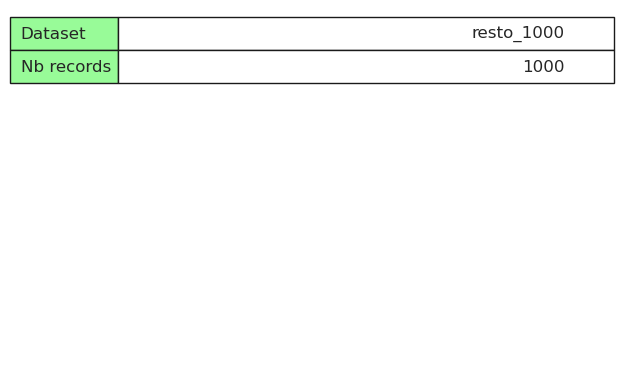

In [2364]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf.savefig( bbox_inches='tight')

# Geocode

In [2365]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [2366]:
#no_res_timing_df.append({"address": "test", "duration": 0.5, "geocoder": "test"}, ignore_index=True)

In [2367]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr, 
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [2368]:
# data

In [2369]:
# data.assign(address=data.street.fillna("") + " "+ data.housenumber.fillna("")).\
#                                  rename(columns={"postcode":"postalcode",
#                                                 "city": "locality"})

In [2370]:
geocoded_data_r = []#gpd.GeoDataFrame()
# coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google", "pelias"]
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google","pelias", "bestaddress"]
# coders=["here", "bing", "mapbox", "tomtom", "google"]
# coders=["nominatim_local", "here", "bing", "tomtom", "google"]
# coders=["nominatim_wrapper", "nominatim_local", "pelias", "bestaddress"]

# coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "google", "lpost_bestaddress", "tomtom"]
# coders=["pelias"]
# from_file = ["nominatim_wrapper", "here", "bing", "mapbox", "tomtom", "google","pelias"] #"here", "bing", "mapbox",  "google",  "lpost_bestaddress", "tomtom"]#"here", "bing", "mapbox", "tomtom", "google",  "nominatim_wrapper","nominatim_local"]#"nominatim_wrapper","nominatim_local", "here", "bing", "mapbox", "tomtom", "trillium", "google"]#"nominatim_local", "photon_local", "here", "bing", "mapbox"]
from_file = coders
# from_file = []
# from_file = ["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox"]

delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim_local":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4}


for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder == "bestaddress": # structured BestAddress
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)
        elif coder == "pelias": # structured pelias
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(lambda d: pelias_struct(geocoders["pelias"], d))).assign(geocoder=coder)
        else: 
            g_data = data.assign(location=data['address'].str.replace("/", "%2F").progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

nominatim_wrapper
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location           geocoder  
0    (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_wrapper  
1    (44, Rue de Liboichant, Vresse-sur-Semois, Din...  nominatim_wrapper  
2    (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_wrapper  
3    (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_wrapper  
4    (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_wrapper  
..                                                 ...                ...  
995  (10, Avenue Paul Deschanel - Paul Deschanellaa...  nominatim_wrapper  
996                                               None  nominatim_wrapper  
997  (29, Grote Markt, Mechelen, Antwerpen, Vlaande...  nominatim_wrapper  
998  (New Azelhof, 201, Aarschotsesteenweg, Konings...  nominatim_wrapper  
999  (Hanswijkstraat, Mechelen, Antwerpen, Vlaander...  nominatim_wrapper  

[1000 rows x 7 columns]

nominatim_local
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location         geocoder  
0    (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_local  
1                                                 None  nominatim_local  
2    (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_local  
3    (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_local  
4    (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_local  
..                                                 ...              ...  
995  (10, Avenue Paul Deschanel - Paul Deschanellaa...  nominatim_local  
996                                               None  nominatim_local  
997  (29, Grote Markt, Mechelen, Antwerpen, Vlaande...  nominatim_local  
998  (New Azelhof, 201, Aarschotsesteenweg, Konings...  nominatim_local  
999  (Hanswijkstraat, Mechelen, Antwerpen, Vlaander...  nominatim_local  

[1000 rows x 7 columns]

here
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location geocoder  
0    (Rue Royale 135, 1000 Bruxelles, Belgique, Bru...     here  
1    (Rue de Liboichant 44, 5550 Vresse-sur-Semois,...     here  
2    (Chaussée d'Alsemberg 741, 1180 Uccle, Belgiqu...     here  
3    (Chaussée de Louvain 922, 1140 Evere, Belgique...     here  
4    (Rue Basse Marcelle 26, 5000 Namur, Belgique, ...     here  
..                                                 ...      ...  
995  (Avenue Paul Deschanel 10, 1030 Schaerbeek, Be...     here  
996  (Boulevard du Triomphe, 1050 Ixelles, Belgique...     here  
997  (Grote Markt 29, 2800 Mechelen, België, Mechel...     here  
998  (Aarschotsesteenweg 201, 2500 Lier, België, Li...     here  
999  (Hanswijkstraat 63, 2800 Mechelen, België, Mec...     here  

[1000 rows x 7 columns]

bing
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location geocoder  
0    (Rue Royale 135, Brussels, Brussels Region 100...     bing  
1    (Rue de Liboichant 44, Vresse-sur-Semois, Wall...     bing  
2    (Chaussée d'alsemberg 741, Ukkel, Brussels Reg...     bing  
3    (Chaussée de Louvain 922, Evere, Brussels Regi...     bing  
4    (Rue Basse Marcelle 26, Namur, Walloon Region ...     bing  
..                                                 ...      ...  
995  (Avenue Paul Deschanel 10, Schaerbeek, Brussel...     bing  
996  (Boulevard du Triomphe, Ixelles, Brussels Regi...     bing  
997  (Grote Markt 29, Mechelen, Flemish Region 2800...     bing  
998  (Aarschotsesteenweg 201, Lier, Flemish Region ...     bing  
999  (Hanswijkstraat 63, Mechelen, Flemish Region 2...     bing  

[1000 rows x 7 columns]

mapbox
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location geocoder  
0    (Rue Royale - Koningsstraat 135, 1000 Brussels...   mapbox  
1    (Rue De Liboichant 44, 5550 Vresse-sur-Semois,...   mapbox  
2    (Chaussée D'alsemberg - Alsembergsesteenweg 74...   mapbox  
3    (Chaussée De Louvain - Leuvensesteenweg 922, 1...   mapbox  
4    (Rue Basse Marcelle 26, 5000 Namur, Namur, Bel...   mapbox  
..                                                 ...      ...  
995  (Avenue Paul Deschanel - Paul Deschanellaan 10...   mapbox  
996  (1050, Ixelles, Brussels-Capital, Belgium, (50...   mapbox  
997  (Grote Markt 29, 2800 Mechelen, Antwerp, Belgi...   mapbox  
998  (Aarschotsesteenweg 201, 2500 Lier, Antwerp, B...   mapbox  
999  (Hanswijkstraat 63, 2800 Mechelen, Antwerp, Be...   mapbox  

[1000 rows x 7 columns]

tomtom
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location geocoder  
0    (Rue Royale 135, 1000 Bruxelles, (50.8521, 4.3...   tomtom  
1    (Rue de Liboichant 44, 5550 Vresse-sur-Semois,...   tomtom  
2    (Chaussée d'Alsemberg 741, 1180 Bruxelles, (50...   tomtom  
3    (Chaussée de Louvain 922, 1140 Bruxelles, (50....   tomtom  
4    (Rue Basse Marcelle 26, 5000 Namur, (50.46458,...   tomtom  
..                                                 ...      ...  
995  (Avenue Paul Deschanel 10, 1030 Bruxelles, (50...   tomtom  
996  (Boulevard du Triomphe, Bruxelles, (50.82222, ...   tomtom  
997  (Grote Markt 29, 2800 Mechelen, (51.02749, 4.4...   tomtom  
998  (Aarschotsesteenweg 201, 2500 Lier, (51.09664,...   tomtom  
999  (Hanswijkstraat 63, 2800 Mechelen, (51.02243, ...   tomtom  

[1000 rows x 7 columns]

google
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location geocoder  
0    (Rue Royale 135, 1000 Bruxelles, Belgium, (50....   google  
1    (Rue de Liboichant 44, 5550 Vresse-sur-Semois,...   google  
2    (Chau. d'Alsemberg 741, 1180 Uccle, Belgium, (...   google  
3    (Chau. de Louvain 922, 1140 Evere, Belgium, (5...   google  
4    (Rue Basse Marcelle 26, 5000 Namur, Belgium, (...   google  
..                                                 ...      ...  
995  (Av. Paul Deschanel 10, 1030 Schaerbeek, Belgi...   google  
996  (Station Delta, 1160 Oudergem, Belgium, (50.81...   google  
997  (Grote Markt 29, 2800 Mechelen, Belgium, (51.0...   google  
998  (Aarschotsesteenweg 201, 2500 Lier, Belgium, (...   google  
999  (Hanswijkstraat 63, 2800 Mechelen, Belgium, (5...   google  

[1000 rows x 7 columns]

pelias
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                            location geocoder  
0             (Centre Quarter, (50.84715, 4.350876))   pelias  
1                        (Alle, (49.84119, 4.97011))   pelias  
2    (Chaussée d'Alsemberg 741, (50.80416, 4.33647))   pelias  
3                     (Evere, (50.864549, 4.400135))   pelias  
4       (Rue Basse Marcelle 26, (50.46458, 4.86153))   pelias  
..                                               ...      ...  
995  (Avenue Paul Deschanel 10, (50.86253, 4.38113))   pelias  
996  (Boulevard Du Triomphe 236, (50.81865, 4.3959))   pelias  
997            (Grote Markt 29, (51.02749, 4.48026))   pelias  
998    (Aarschotsesteenweg 201, (51.09577, 4.62147))   pelias  
999      (Hanswijkstraat 63, (51.0220463, 4.485464))   pelias  

[1000 rows x 7 columns]

bestaddress
Load from local file...


street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  \
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
..                ...                                                ...   
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                              location     geocoder  
0    (Rue Royale, , 1000 Bruxelles , (50.843498465,...  bestaddress  
1    (Rue de Liboichant, 44, 5550 Vresse-sur-Semois...  bestaddress  
2    (Chaussée d'Alsemberg, 741, 1180 Uccle , (50.8...  bestaddress  
3    (Chaussée de Louvain, 922, 1140 Evere , (50.85...  bestaddress  
4    (Rue Basse Marcelle, 26, 5000 Namur (Namur), (...  bestaddress  
..                                                 ...          ...  
995  (Avenue Paul Deschanel, 10, 1030 Schaerbeek , ...  bestaddress  
996  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...  bestaddress  
997  (Grote Markt, 29, 2800 Malines , (51.027492847...  bestaddress  
998  (Aarschotsesteenweg, 201, 2500 Lierre , (51.09...  bestaddress  
999  (Hanswijkstraat, , 2800 Malines , (51.02258524...  bestaddress  

[1000 rows x 7 columns]

In [2371]:
# dataset

## Gather results

In [2372]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

street housenumber postcode  \
0                                            Rue Royale         135     1000   
1                                     Rue de Liboichant          44     5550   
2                                  Chaussée d'Alsemberg         741     1180   
3                                   Chaussée de Louvain         922     1140   
4                                    Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
8995                              Avenue Paul Deschanel          10     1030   
8996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
8997                                        Grote Markt          29     2800   
8998                                 Aarschotsesteenweg         201     2500   
8999                                     Hanswijkstraat          63     2800   

                  city                                            address  \
0     BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                 ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2                UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3                EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4                NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
8995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
8996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
8997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
8998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
8999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                               location           geocoder  
0     (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_wrapper  
1     (44, Rue de Liboichant, Vresse-sur-Semois, Din...  nominatim_wrapper  
2     (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_wrapper  
3     (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_wrapper  
4     (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_wrapper  
...                                                 ...                ...  
8995  (Avenue Paul Deschanel, 10, 1030 Schaerbeek , ...        bestaddress  
8996  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...        bestaddress  
8997  (Grote Markt, 29, 2800 Malines , (51.027492847...        bestaddress  
8998  (Aarschotsesteenweg, 201, 2500 Lierre , (51.09...        bestaddress  
8999  (Hanswijkstraat, , 2800 Malines , (51.02258524...        bestaddress  

[8704 rows x 7 columns]

In [2373]:
geocoded_data.geocoder.value_counts()

mapbox               1000
here                  999
bing                  999
tomtom                998
google                998
pelias                992
nominatim_wrapper     989
nominatim_local       887
bestaddress           842
Name: geocoder, dtype: int64

In [2374]:
# geocoded_data[geocoded_data.street=="LANGESTRAAT(OW)"]

## Duration

In [2375]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [2376]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


8704

In [2377]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [2378]:
# if len(no_res_timing) >0:
#     no_res_timing_df = pd.concat([pd.DataFrame(no_res_timing[x]).rename(columns={0:"address", 1:"duration"}).assign(geocoder=x) for x in no_res_timing])#.drop("index", axis=1)
#     #pd.DataFrame(no_res_timing).unstack().rename("duration").reset_index().rename(columns={"level_0": "geocoder"}).drop("level_1", axis=1)
#     no_res_timing_df["duration"] = no_res_timing_df["duration"].dt.total_seconds()
    
#     no_res_timing_df.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
# else: 
#     try: 
#         no_res_timing_df = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
#     except FileNotFoundError: 
#         no_res_timing_df = pd.DataFrame(columns =["address", "geocoder", "duration"] )
# no_res_timing_df

In [2379]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), no_res_timing.assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [2380]:
geocoded_data_duration

address           geocoder  \
0      Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique  nominatim_wrapper   
1            Rue de Liboichant, 44, 5550 ALLE, Belgique  nominatim_wrapper   
2       Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique  nominatim_wrapper   
3        Chaussée de Louvain, 922, 1140 EVERE, Belgique  nominatim_wrapper   
4          Rue Basse Marcelle, 26, 5000 NAMUR, Belgique  nominatim_wrapper   
...                                                 ...                ...   
8836  Midzele, 27, 2860 WAVRE-SAINTE-CATHERINE, Belg...             pelias   
8837      Waalse kaai, 40, 2000 ANVERS-CENTRE, Belgique             pelias   
8838               Centre, 50, 4890 THIMISTER, Belgique             pelias   
8839   830 Nationale | Naninne, 4, 5100 NAMUR, Belgique             pelias   
8840  Boulevard du Triomphe Accès 4 de l'ULB (statio...             pelias   

      duration  with_result  
0     0.054017         True  
1     0.484434         True  
2     0.031772         True  
3     0.022083         True  
4     0.020958         True  
...        ...          ...  
8836  0.010332        False  
8837  0.016509        False  
8838  0.010486        False  
8839  0.013422        False  
8840  0.016225        False  

[8841 rows x 4 columns]

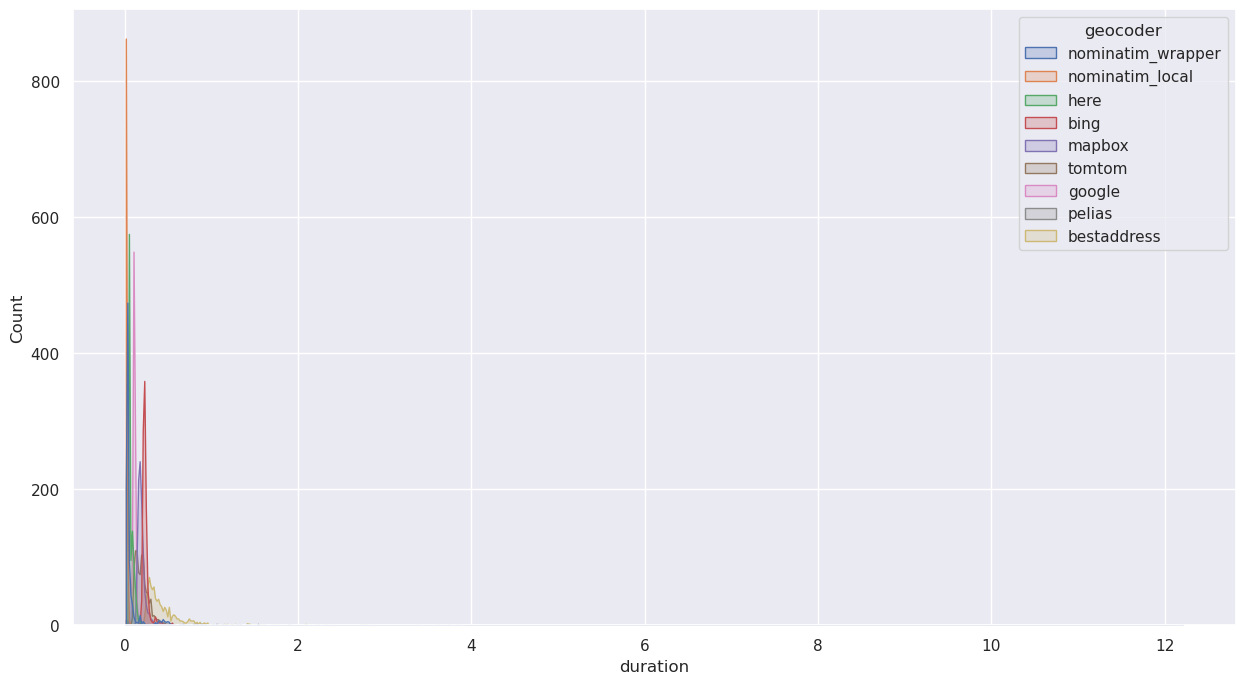

In [2381]:
plt.figure(figsize=(15,8))
sbn.histplot(geocoded_data_duration, x="duration", hue="geocoder", element="poly", )
pdf.savefig(bbox_inches='tight')

In [2382]:
# pd.concat([geocoded_data, no_res_timing_df]).groupby("geocoder").duration.mean()

In [2383]:
# geocoded_data.groupby("geocoder").duration.mean()

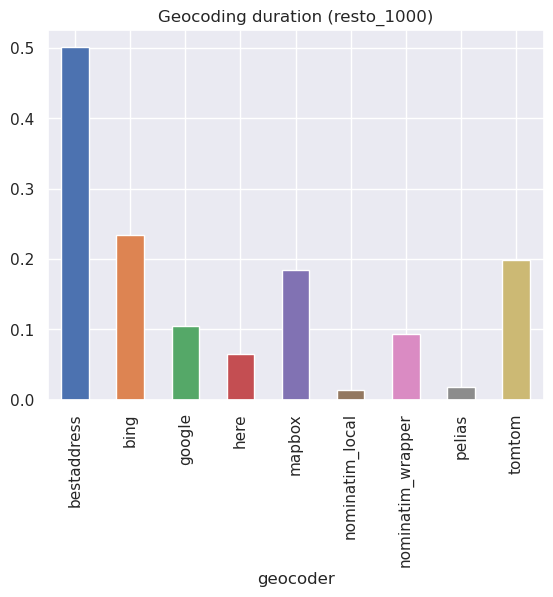

In [2384]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, title=f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

<Axes: title={'center': 'Geocoding duration (resto_1000)'}, xlabel='geocoder'>

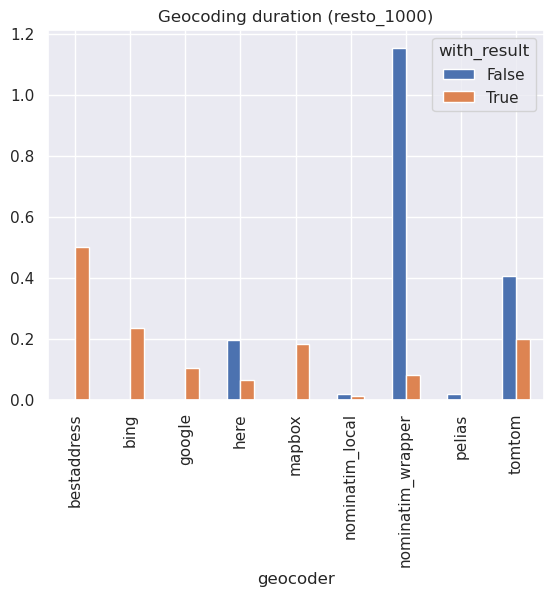

In [2385]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})")

In [2386]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

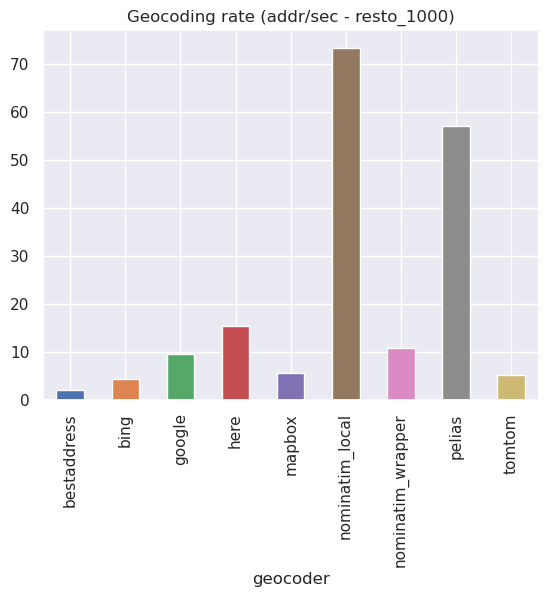

In [2387]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, title=f"Geocoding rate (addr/sec - {dataset})")
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

In [2388]:
geocoded_data_duration[geocoded_data_duration[["address", "geocoder"]].duplicated(keep=False)]

address           geocoder  \
49            Rue du Couloir, 5, 1050 IXELLES, Belgique  nominatim_wrapper   
168        Rue du Mouton Blanc, 4, 4000 LIEGE, Belgique  nominatim_wrapper   
365        Rue du Mouton Blanc, 4, 4000 LIEGE, Belgique  nominatim_wrapper   
498   Chaussée de Gramptinne, 10, 5340 GESVES, Belgique  nominatim_wrapper   
553           Rue du Pot d'Or, 33, 4000 LIEGE, Belgique  nominatim_wrapper   
...                                                 ...                ...   
8831  Fonds Sainte Julienne (Domaine de la Julienne)...             pelias   
8833  Waagnatie Expo & Events  Rijnkaai, 150, 2000 A...             pelias   
8838               Centre, 50, 4890 THIMISTER, Belgique             pelias   
8839   830 Nationale | Naninne, 4, 5100 NAMUR, Belgique             pelias   
8840  Boulevard du Triomphe Accès 4 de l'ULB (statio...             pelias   

      duration  with_result  
49    0.020695         True  
168   0.022634         True  
365   0.020704         True  
498   0.028337         True  
553   0.020467         True  
...        ...          ...  
8831  0.035913        False  
8833  0.020450        False  
8838  0.010486        False  
8839  0.013422        False  
8840  0.016225        False  

[150 rows x 4 columns]

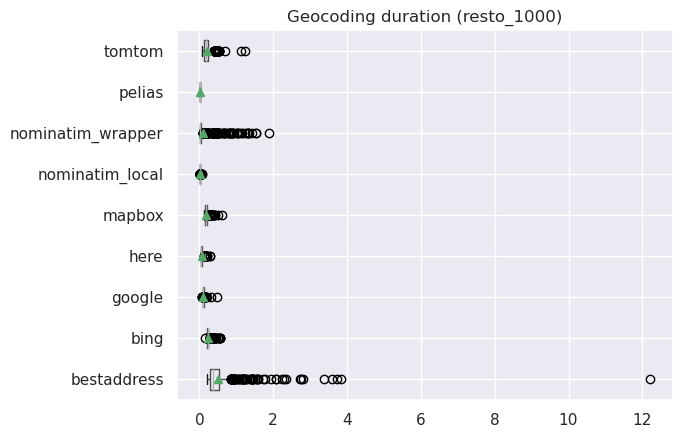

In [2389]:
d = geocoded_data_duration.drop_duplicates(subset=["address",  "geocoder"]).pivot(index="address", columns="geocoder", values="duration")
ax = d.boxplot(showmeans=True, vert=False)
plt.title(f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed_boxplot.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')
# ax.set_yscale("log")

In [2390]:
geocoded_data[["geocoder", "duration"]].groupby("geocoder").describe()


duration                                                    \
                     count      mean       std       min       25%       50%   
geocoder                                                                       
bestaddress          842.0  0.500486  0.554054  0.216256  0.299990  0.373771   
bing                 999.0  0.233739  0.043850  0.152514  0.212380  0.224021   
google               998.0  0.104524  0.019303  0.034109  0.095826  0.102813   
here                 999.0  0.065023  0.030348  0.035926  0.043456  0.047401   
mapbox              1000.0  0.183497  0.044481  0.032549  0.158745  0.175163   
nominatim_local      887.0  0.012951  0.005819  0.008036  0.009758  0.011063   
nominatim_wrapper    989.0  0.081718  0.169294  0.015781  0.021025  0.025019   
pelias                 0.0       NaN       NaN       NaN       NaN       NaN   
tomtom               998.0  0.198142  0.093261  0.037965  0.132151  0.187464   

                                        
                        75%        max  
geocoder                                
bestaddress        0.516991  12.216740  
bing               0.238997   0.551152  
google             0.111730   0.469307  
here               0.080146   0.290179  
mapbox             0.198263   0.625242  
nominatim_local    0.013644   0.066827  
nominatim_wrapper  0.048805   1.882470  
pelias                  NaN        NaN  
tomtom             0.235582   1.241731

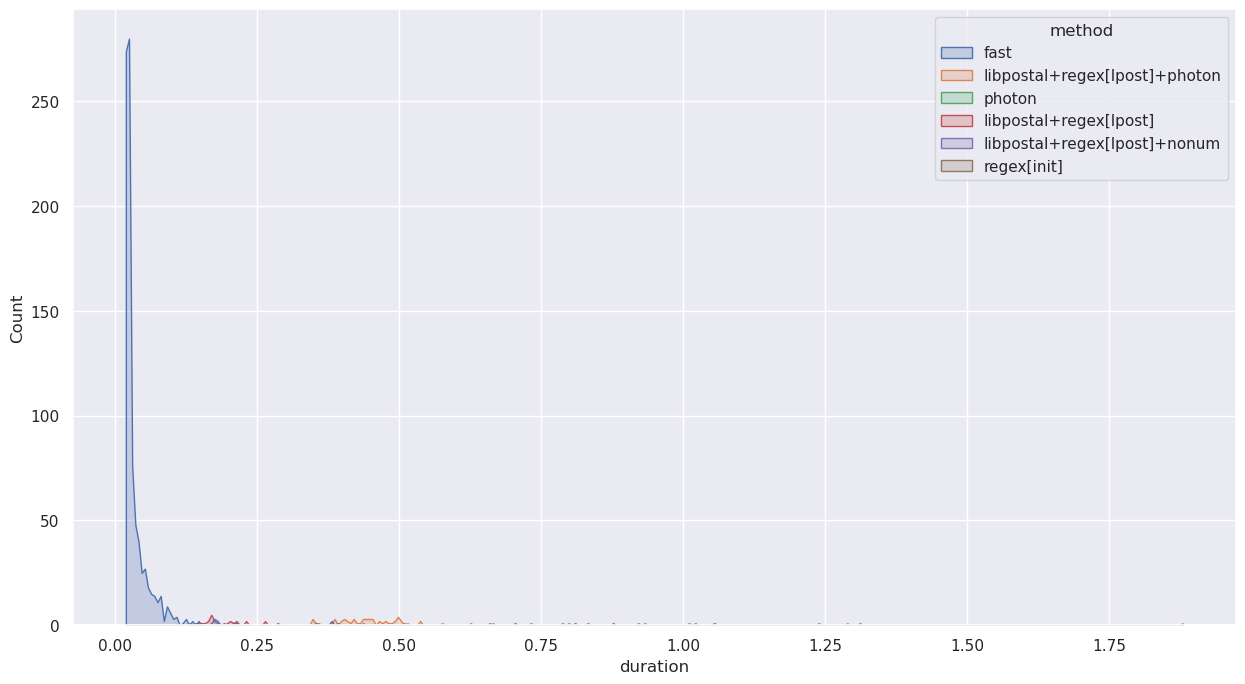

In [2391]:
if "nominatim_wrapper" in coders:
    nw = geocoded_data[geocoded_data.geocoder=="nominatim_wrapper"]
    nw = nw.assign(method=nw.location.apply(lambda x:x.raw["metadata"]["method"]))
    plt.figure(figsize=(15,8))
    g =sbn.histplot(nw, x="duration", hue="method", element="poly")
    # g.set_yscale('log')

# nw

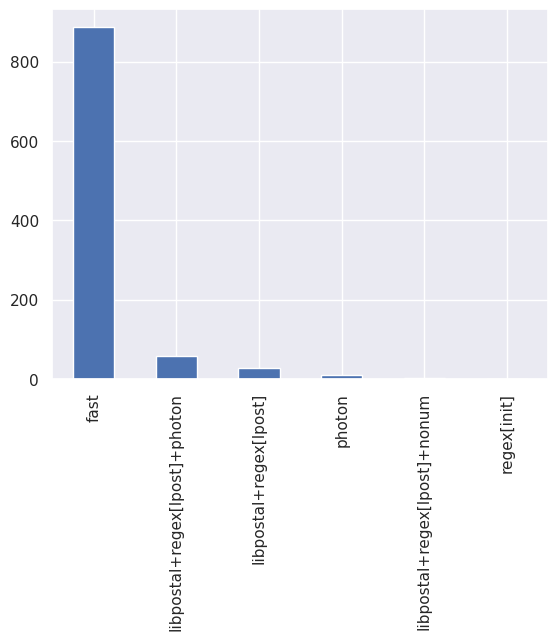

In [2392]:
if "nominatim_wrapper" in coders:
    nw.method.value_counts().plot.bar()

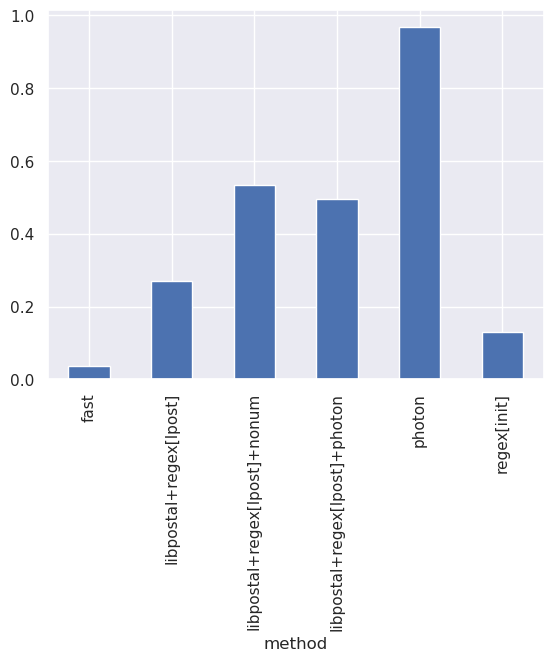

In [2393]:
# sbn.barplot(nw.groupby("method").address.count().reset_index(), x="method", y="address")
if "nominatim_wrapper" in coders:
    nw.groupby("method").duration.mean().plot.bar()

## Extract precision

In [2394]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [2395]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

geocoder  precision                   
mapbox    [UNKNOWN]                       67
here      [UNKNOWN - district]             3
bing      [UNKNOWN - Neighborhood]         1
          [UNKNOWN - RoadIntersection]     1
dtype: int64

In [2396]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

In [2397]:
# geocoded_data[geocoded_data.precision== "[UNKNOWN - APPROXIMATE]"].iloc[-1].location.raw

In [2398]:
# geocoded_data[geocoded_data.precision== "[UNKNOWN - APPROXIMATE]"]

In [2399]:
# geocoded_data.loc[599].location.raw#["entityType"]

In [2400]:
# geocoders["mapbox"].geocode("2627 Schelle").raw

In [2401]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [2402]:
geocoded_data

street housenumber postcode  \
0                                            Rue Royale         135     1000   
1                                     Rue de Liboichant          44     5550   
2                                  Chaussée d'Alsemberg         741     1180   
3                                   Chaussée de Louvain         922     1140   
4                                    Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
8995                              Avenue Paul Deschanel          10     1030   
8996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
8997                                        Grote Markt          29     2800   
8998                                 Aarschotsesteenweg         201     2500   
8999                                     Hanswijkstraat          63     2800   

                  city                                            address  \
0     BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                 ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2                UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3                EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4                NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
8995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
8996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
8997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
8998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
8999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                               location           geocoder  \
0     (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_wrapper   
1     (44, Rue de Liboichant, Vresse-sur-Semois, Din...  nominatim_wrapper   
2     (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_wrapper   
3     (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_wrapper   
4     (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_wrapper   
...                                                 ...                ...   
8995  (Avenue Paul Deschanel, 10, 1030 Schaerbeek , ...        bestaddress   
8996  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...        bestaddress   
8997  (Grote Markt, 29, 2800 Malines , (51.027492847...        bestaddress   
8998  (Aarschotsesteenweg, 201, 2500 Lierre , (51.09...        bestaddress   
8999  (Hanswijkstraat, , 2800 Malines , (51.02258524...        bestaddress   

      duration precision                                  point  
0     0.054017  building             POINT (4.36536 50.8520985)  
1     0.484434  building   POINT (4.969619832815811 49.8481802)  
2     0.031772  building  POINT (4.336366818205258 50.80416595)  
3     0.022083  building   POINT (4.413909061740533 50.8587314)  
4     0.020958  building   POINT (4.861534798795159 50.4645976)  
...        ...       ...                                    ...  
8995  0.300006  building       POINT (4.381135128 50.862534129)  
8996  0.566713      city                            POINT (0 0)  
8997  0.283218  building       POINT (4.480259053 51.027492847)  
8998  0.316821  building       POINT (4.621470843 51.095771133)  
8999  0.583195    street       POINT (4.483808189 51.022585248)  

[8704 rows x 10 columns]

In [2403]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

street housenumber postcode  \
0                                            Rue Royale         135     1000   
1                                     Rue de Liboichant          44     5550   
2                                  Chaussée d'Alsemberg         741     1180   
3                                   Chaussée de Louvain         922     1140   
4                                    Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
8995                              Avenue Paul Deschanel          10     1030   
8996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
8997                                        Grote Markt          29     2800   
8998                                 Aarschotsesteenweg         201     2500   
8999                                     Hanswijkstraat          63     2800   

                  city                                            address  \
0     BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                 ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2                UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3                EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4                NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
8995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
8996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
8997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
8998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
8999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                               location           geocoder  \
0     (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_wrapper   
1     (44, Rue de Liboichant, Vresse-sur-Semois, Din...  nominatim_wrapper   
2     (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_wrapper   
3     (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_wrapper   
4     (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_wrapper   
...                                                 ...                ...   
8995  (Avenue Paul Deschanel, 10, 1030 Schaerbeek , ...        bestaddress   
8996  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...        bestaddress   
8997  (Grote Markt, 29, 2800 Malines , (51.027492847...        bestaddress   
8998  (Aarschotsesteenweg, 201, 2500 Lierre , (51.09...        bestaddress   
8999  (Hanswijkstraat, , 2800 Malines , (51.02258524...        bestaddress   

      duration precision                           point  
0     0.054017  building  POINT (485949.652 6595173.241)  
1     0.484434  building  POINT (553215.549 6420024.722)  
2     0.031772  building  POINT (482722.146 6586725.781)  
3     0.022083  building  POINT (491354.109 6596342.883)  
4     0.020958  building  POINT (541183.578 6527128.145)  
...        ...       ...                             ...  
8995  0.300006  building  POINT (487705.732 6597013.529)  
8996  0.566713      city             POINT (0.000 0.000)  
8997  0.283218  building  POINT (498740.156 6626158.331)  
8998  0.316821  building  POINT (514459.781 6638252.044)  
8999  0.583195    street  POINT (499135.244 6625289.764)  

[8704 rows x 10 columns]

In [2404]:
geocoded_data[(geocoded_data.geocoder=="pelias") & (geocoded_data.precision=="building")]#.precision.value_counts()

street housenumber postcode        city  \
7002   Chaussée d'Alsemberg         741     1180       UCCLE   
7004     Rue Basse Marcelle          26     5000       NAMUR   
7005            Steegstraat           8     2490       BALEN   
7006  Avenue de la couronne         375     1050     IXELLES   
7007             Rue Grande          91     5500      DINANT   
...                     ...         ...      ...         ...   
7992   Rue Haute-Sauvenière          39     4000       LIEGE   
7993              Achterbos          67     2400         MOL   
7995  Avenue Paul Deschanel          10     1030  SCHAERBEEK   
7997            Grote Markt          29     2800     MALINES   
7998     Aarschotsesteenweg         201     2500        LIER   

                                                address  \
7002    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
7004       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
7005               Steegstraat, 8, 2490 BALEN, Belgique   
7006  Avenue de la couronne, 375, 1050 IXELLES, Belg...   
7007              Rue Grande, 91, 5500 DINANT, Belgique   
...                                                 ...   
7992     Rue Haute-Sauvenière, 39, 4000 LIEGE, Belgique   
7993                  Achterbos, 67, 2400 MOL, Belgique   
7995  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
7997            Grote Markt, 29, 2800 MALINES, Belgique   
7998       Aarschotsesteenweg, 201, 2500 LIER, Belgique   

                                              location geocoder  duration  \
7002   (Chaussée d'Alsemberg 741, (50.80416, 4.33647))   pelias       NaN   
7004      (Rue Basse Marcelle 26, (50.46458, 4.86153))   pelias       NaN   
7005               (Steegstraat 8, (51.16984, 5.1685))   pelias       NaN   
7006  (Avenue De La Couronne 375, (50.81771, 4.39231))   pelias       NaN   
7007              (Rue Grande 91, (50.25846, 4.91422))   pelias       NaN   
...                                                ...      ...       ...   
7992    (Rue Haute-Sauvenière 39, (50.64535, 5.56945))   pelias       NaN   
7993               (Achterbos 67, (51.20178, 5.09785))   pelias       NaN   
7995   (Avenue Paul Deschanel 10, (50.86253, 4.38113))   pelias       NaN   
7997             (Grote Markt 29, (51.02749, 4.48026))   pelias       NaN   
7998     (Aarschotsesteenweg 201, (51.09577, 4.62147))   pelias       NaN   

     precision                           point  
7002  building  POINT (482733.632 6586724.733)  
7004  building  POINT (541183.044 6527125.068)  
7005  building  POINT (575354.788 6651391.618)  
7006  building  POINT (488949.713 6589111.856)  
7007  building  POINT (547048.468 6491157.462)  
...        ...                             ...  
7992  building  POINT (619988.338 6558798.393)  
7993  building  POINT (567490.066 6657064.181)  
7995  building  POINT (487705.161 6597012.801)  
7997  building  POINT (498740.262 6626157.827)  
7998  building  POINT (514459.687 6638251.843)  

[444 rows x 10 columns]

In [2405]:
geocoded_data[(geocoded_data.geocoder=="pelias") & (geocoded_data.precision=="building")].location.apply(lambda l: l.raw["properties"]["source"]).value_counts()

openaddresses    427
openstreetmap     17
Name: location, dtype: int64

In [2406]:
# geocoded_data.loc[7863].location.raw

In [2407]:
pelias_struct(geocoders["pelias"], {"street": "Avenue Paul Deschanel",
                                    "housenumber": 10,
                                    "city": "schaerbeek",
                                    "postcode": "1030"}).raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [4.38113, 50.86253]},
 'properties': {'id': 'be/bru/bosa-region-brussels-fr:6a19deba705d26e6',
  'gid': 'openaddresses:address:be/bru/bosa-region-brussels-fr:6a19deba705d26e6',
  'layer': 'address',
  'source': 'openaddresses',
  'source_id': 'be/bru/bosa-region-brussels-fr:6a19deba705d26e6',
  'country_code': 'BE',
  'name': 'Avenue Paul Deschanel 10',
  'housenumber': '10',
  'street': 'Avenue Paul Deschanel',
  'postalcode': '1030',
  'confidence': 1,
  'match_type': 'exact',
  'distance': 2.594,
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'region': 'Brussels',
  'region_gid': 'whosonfirst:region:85681713',
  'region_a': 'BU',
  'neighbourhood': 'Schaarbeek',
  'neighbourhood_gid': 'whosonfirst:neighbourhood:85801855',
  'label': 'Avenue Paul Deschanel 10, BU, Belgium'},
 'call_type': 'unstruct'}

In [2408]:
geocoders["pelias"].geocode("Avenue Paul Deschanel, 10, 1030 SCHAERBEEK").raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [4.38113, 50.86253]},
 'properties': {'id': 'be/bru/bosa-region-brussels-fr:6a19deba705d26e6',
  'gid': 'openaddresses:address:be/bru/bosa-region-brussels-fr:6a19deba705d26e6',
  'layer': 'address',
  'source': 'openaddresses',
  'source_id': 'be/bru/bosa-region-brussels-fr:6a19deba705d26e6',
  'country_code': 'BE',
  'name': 'Avenue Paul Deschanel 10',
  'housenumber': '10',
  'street': 'Avenue Paul Deschanel',
  'postalcode': '1030',
  'confidence': 1,
  'match_type': 'exact',
  'distance': 2.594,
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'region': 'Brussels',
  'region_gid': 'whosonfirst:region:85681713',
  'region_a': 'BU',
  'neighbourhood': 'Schaarbeek',
  'neighbourhood_gid': 'whosonfirst:neighbourhood:85801855',
  'label': 'Avenue Paul Deschanel 10, BU, Belgium'}}

In [2409]:
pelias_res = geocoded_data[(geocoded_data.geocoder=="pelias")].copy()

In [2410]:
pelias_res#.location.iloc[0].raw

street housenumber postcode  \
7000                                         Rue Royale         135     1000   
7001                                  Rue de Liboichant          44     5550   
7002                               Chaussée d'Alsemberg         741     1180   
7003                                Chaussée de Louvain         922     1140   
7004                                 Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
7995                              Avenue Paul Deschanel          10     1030   
7996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
7997                                        Grote Markt          29     2800   
7998                                 Aarschotsesteenweg         201     2500   
7999                                     Hanswijkstraat          63     2800   

                  city                                            address  \
7000  BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
7001              ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
7002             UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
7003             EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
7004             NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
7995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
7996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
7997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
7998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
7999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                             location geocoder  duration  \
7000           (Centre Quarter, (50.84715, 4.350876))   pelias       NaN   
7001                      (Alle, (49.84119, 4.97011))   pelias       NaN   
7002  (Chaussée d'Alsemberg 741, (50.80416, 4.33647))   pelias       NaN   
7003                   (Evere, (50.864549, 4.400135))   pelias       NaN   
7004     (Rue Basse Marcelle 26, (50.46458, 4.86153))   pelias       NaN   
...                                               ...      ...       ...   
7995  (Avenue Paul Deschanel 10, (50.86253, 4.38113))   pelias       NaN   
7996  (Boulevard Du Triomphe 236, (50.81865, 4.3959))   pelias       NaN   
7997            (Grote Markt 29, (51.02749, 4.48026))   pelias       NaN   
7998    (Aarschotsesteenweg 201, (51.09577, 4.62147))   pelias       NaN   
7999      (Hanswijkstraat 63, (51.0220463, 4.485464))   pelias       NaN   

     precision                           point  
7000      city  POINT (484337.301 6594300.734)  
7001      city  POINT (553270.114 6418818.037)  
7002  building  POINT (482733.632 6586724.733)  
7003      city  POINT (489820.788 6597368.893)  
7004  building  POINT (541183.044 6527125.068)  
...        ...                             ...  
7995  building  POINT (487705.161 6597012.801)  
7996    street  POINT (489349.350 6589277.483)  
7997  building  POINT (498740.262 6626157.827)  
7998  building  POINT (514459.687 6638251.843)  
7999    street  POINT (499319.568 6625194.385)  

[992 rows x 10 columns]

In [2411]:
pelias_res["pelias_street"] = pelias_res.location.apply(lambda loc: loc.raw["properties"]["street"] if "street" in loc.raw["properties"] else None)
pelias_res["call_type"] = pelias_res.location.apply(lambda loc: loc.raw["call_type"])

In [2412]:
import jellyfish
pelias_res["dist"] = pelias_res.fillna("").progress_apply(lambda rec: jellyfish.jaro_winkler_similarity(rec["street"].upper(), rec["pelias_street"].upper()), axis=1)
#.iloc[0].location.raw

100%|██████████| 992/992 [00:00<00:00, 91390.81it/s]


In [2413]:
pelias_res[pelias_res.dist >0].sort_values("dist")[["street", "pelias_street", "dist", "call_type"]].iloc[0:60]

street  \
7199                  Waagnatie Expo & Events  Rijnkaai   
7471                                         Rue Defack   
7459                                     Gentsesteenweg   
7294                                  Amerikaansestraat   
7697                                  Amerikaansestraat   
7529  Route de Jalhay | Ce restaurant s appelait ava...   
7286                                  Rue Lessbroussart   
7135               Docks Bruxsel - Boulevard Lambermont   
7950                                     Bld Léopold II   
7693                                          Keyserlei   
7914                                 Bld Gustave Kleyer   
7120                                     Du Sacre Coeur   
7044                                    Thier du moulin   
7912                                 Pl. Xavier-Neujean   
7985                    Av. du Bourgmestre Jean Materne   
7153              Mechelsebaan 249, Duffel 2570, België   
7849                                       Place Meiser   
7052                                 Chée. de Charleroi   
7996  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
7248                Rue de la Gare 37, Spa 4900, België   
7920                                        Rue Jourdan   
7036                                        Rue Jourdan   
7031                                        Rue Jourdan   
7694                                        Rue Jourdan   
7518                       Rue d'Alleur 27c, 4000 Liège   
7536                                   Chaussée de Mons   
7236                              Avenue d'Auderghem 54   
7391                               Rue Washingtonstraat   
7645                                      Place jourdan   
7401                     Fourmoisstraat 32, 1050 Elsene   
7123                                    Rue des Tongres   
7346                               chaussée d'Alsemberg   
7311                              Chaussée de Charleroi   
7546                              Chaussée de Charleroi   
7450                                   Avenue Churchill   
7191                                   chaussée de gand   
7322                                 Chaussée de Haecht   
7871                                Chaussée de Louvain   
7386                                Chaussée de Louvain   
7762                                      Avenue Chazal   
7817                              Chaussée de Roodebeek   
7470                                      Rue de la Loi   
7092                                      rue de la Loi   
7061                                      rue de la Loi   
7091                                        Rue St Paul   
7774                                   rue Hongr&#279;e   
7903                            Boulevard Simon Bolivar   
7882                                    Av Joseph Abras   
7095                                   Rue Haute-Vinave   
7187                                 Avenue L. Lepoutre   
7734                                      Place F. Cocq   
7227                              Rue lulay des febvres   
7968                           Place Marche aux Legumes   
7720                                    rue St. Georges   
7821                              Chaussee de Charleroi   
7556                                      Rue St Hubert   
7257                                    pl. du Monument   
7860                                   PLACE DU THEATRE   
7632                                  Chaussee de Heusy   
7758                                 Rue Gustave Fievet   

                                     pelias_street      dist call_type  
7199                                      Rijnkaai  0.373737  unstruct  
7471                     Rue Caroly - Carolystraat  0.557778  unstruct  
7459             Chaussée de Gand - Gentsesteenweg  0.601371  unstruct  
7294                                   Troonstraat  0.607620  unstruct  
7697                                   Troonstraat  0.607620  unstruct  
7529       

In [2414]:
pelias_res#.loc[7117]

street housenumber postcode  \
7000                                         Rue Royale         135     1000   
7001                                  Rue de Liboichant          44     5550   
7002                               Chaussée d'Alsemberg         741     1180   
7003                                Chaussée de Louvain         922     1140   
7004                                 Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
7995                              Avenue Paul Deschanel          10     1030   
7996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
7997                                        Grote Markt          29     2800   
7998                                 Aarschotsesteenweg         201     2500   
7999                                     Hanswijkstraat          63     2800   

                  city                                            address  \
7000  BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
7001              ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
7002             UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
7003             EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
7004             NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
7995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
7996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
7997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
7998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
7999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                             location geocoder  duration  \
7000           (Centre Quarter, (50.84715, 4.350876))   pelias       NaN   
7001                      (Alle, (49.84119, 4.97011))   pelias       NaN   
7002  (Chaussée d'Alsemberg 741, (50.80416, 4.33647))   pelias       NaN   
7003                   (Evere, (50.864549, 4.400135))   pelias       NaN   
7004     (Rue Basse Marcelle 26, (50.46458, 4.86153))   pelias       NaN   
...                                               ...      ...       ...   
7995  (Avenue Paul Deschanel 10, (50.86253, 4.38113))   pelias       NaN   
7996  (Boulevard Du Triomphe 236, (50.81865, 4.3959))   pelias       NaN   
7997            (Grote Markt 29, (51.02749, 4.48026))   pelias       NaN   
7998    (Aarschotsesteenweg 201, (51.09577, 4.62147))   pelias       NaN   
7999      (Hanswijkstraat 63, (51.0220463, 4.485464))   pelias       NaN   

     precision                           point          pelias_street  \
7000      city  POINT (484337.301 6594300.734)                   None   
7001      city  POINT (553270.114 6418818.037)                   None   
7002  building  POINT (482733.632 6586724.733)   Chaussée d'Alsemberg   
7003      city  POINT (489820.788 6597368.893)                   None   
7004  building  POINT (541183.044 6527125.068)     Rue Basse Marcelle   
...        ...                             ...                    ...   
7995  building  POINT (487705.161 6597012.801)  Avenue Paul Deschanel   
7996    street  POINT (489349.350 6589277.483)  Boulevard Du Triomphe   
7997  building  POINT (498740.262 6626157.827)            Grote Markt   
7998  building  POINT (514459.687 6638251.843)     Aarschotsesteenweg   
7999    street  POINT (499319.568 6625194.385)         Hanswijkstraat   

     call_type      dist  
7000  unstruct  0.000000  
7001    struct  0.000000  
7002  unstruct  1.000000  
7003  unstruct  0.000000  
7004    struct  1.000000  
...        ...       ...  
7995  unstruct  1.000000  
7996  unstruct  0.877778  
7997  unstruct  1.000000  
7998    struct  1.000000  
7999  unstruct  1.000000  

[992 rows x 13 columns]

<Axes: ylabel='source'>

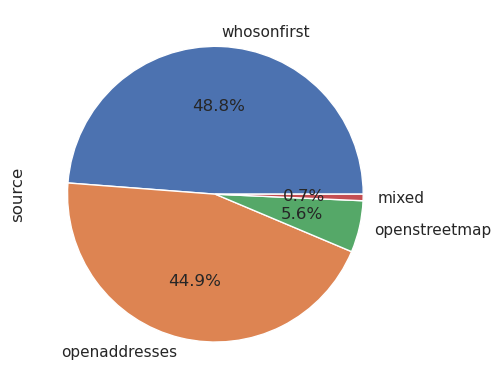

In [2415]:
pelias_res["source"] = pelias_res.location.apply(lambda loc: loc.raw["properties"]["source"])
pelias_res["source"].value_counts().plot.pie(autopct='%1.1f%%')

In [2416]:
pelias_res[["precision", "source"]].value_counts()

precision  source       
city       whosonfirst      484
building   openaddresses    427
street     openstreetmap     31
           openaddresses     18
building   openstreetmap     17
city       openstreetmap      8
street     mixed              7
dtype: int64

In [2417]:
pelias_res.pelias_street.value_counts()

Mechelsesteenweg        6
Avenue Louise           6
Grote Markt             6
Bredabaan               5
Chaussée d'Alsemberg    5
                       ..
Rue Du Tennis           1
Rue De La Halle         1
Paveestraße             1
Chaussée De Liège       1
Hanswijkstraat          1
Name: pelias_street, Length: 380, dtype: int64

In [2418]:
pelias_struct(geocoders["pelias"], {"street": "Rue du Hock",
                                    "housenumber": "36",
                                    "city": "Neupré",
                                    "postcode": "4121"}).raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [5.45564, 50.55351]},
 'properties': {'id': 'be/wal/bosa-region-wallonia-fr:1db51dc14038992c',
  'gid': 'openaddresses:address:be/wal/bosa-region-wallonia-fr:1db51dc14038992c',
  'layer': 'address',
  'source': 'openaddresses',
  'source_id': 'be/wal/bosa-region-wallonia-fr:1db51dc14038992c',
  'country_code': 'BE',
  'name': 'Rue Du Hock 36',
  'housenumber': '36',
  'street': 'Rue Du Hock',
  'postalcode': '4121',
  'confidence': 1,
  'match_type': 'exact',
  'distance': 84.651,
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Wallonia',
  'macroregion_gid': 'whosonfirst:macroregion:404227353',
  'region': 'Liège',
  'region_gid': 'whosonfirst:region:85681691',
  'region_a': 'LG',
  'county': 'Liège',
  'county_gid': 'whosonfirst:county:102049941',
  'county_a': 'LG',
  'locality': 'Neupré',
  'locality_gid': 'whosonfirst:locality:10

In [2419]:
geocoders["pelias"].geocode({"address": "Route de Marche, 43",
                                    "locality": "durbuy",
                                    "postalcode": "6940"}).raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [5.460097, 50.350522]},
 'properties': {'id': '101839741',
  'gid': 'whosonfirst:locality:101839741',
  'layer': 'locality',
  'source': 'whosonfirst',
  'source_id': '101839741',
  'country_code': 'BE',
  'name': 'Durbuy',
  'confidence': 0.6,
  'match_type': 'fallback',
  'distance': 96.143,
  'accuracy': 'centroid',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Wallonia',
  'macroregion_gid': 'whosonfirst:macroregion:404227353',
  'region': 'Luxembourg',
  'region_gid': 'whosonfirst:region:85681727',
  'region_a': 'LX',
  'county': 'Marche-en-Famenne',
  'county_gid': 'whosonfirst:county:102049921',
  'locality': 'Durbuy',
  'locality_gid': 'whosonfirst:locality:101839741',
  'label': 'Durbuy, LX, Belgium',
  'addendum': {'concordances': {'gn:id': 2799047,
    'gp:id': 969190,
    'qs_pg:id': 4312,
    'wd:id': 'Q497697',
    'wk:page': 'Durbuy'}}},
 '

In [2420]:
geocoders["pelias"].geocode("Route de Marche, durbuy").raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [5.460097, 50.350522]},
 'properties': {'id': '101839741',
  'gid': 'whosonfirst:locality:101839741',
  'layer': 'locality',
  'source': 'whosonfirst',
  'source_id': '101839741',
  'country_code': 'BE',
  'name': 'Durbuy',
  'confidence': 0.6,
  'match_type': 'fallback',
  'distance': 96.143,
  'accuracy': 'centroid',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Wallonia',
  'macroregion_gid': 'whosonfirst:macroregion:404227353',
  'region': 'Luxembourg',
  'region_gid': 'whosonfirst:region:85681727',
  'region_a': 'LX',
  'county': 'Marche-en-Famenne',
  'county_gid': 'whosonfirst:county:102049921',
  'county_a': 'MR',
  'locality': 'Durbuy',
  'locality_gid': 'whosonfirst:locality:101839741',
  'label': 'Durbuy, LX, Belgium'},
 'bbox': [5.44876634312, 50.341101571, 5.4745759449, 50.3585984184]}

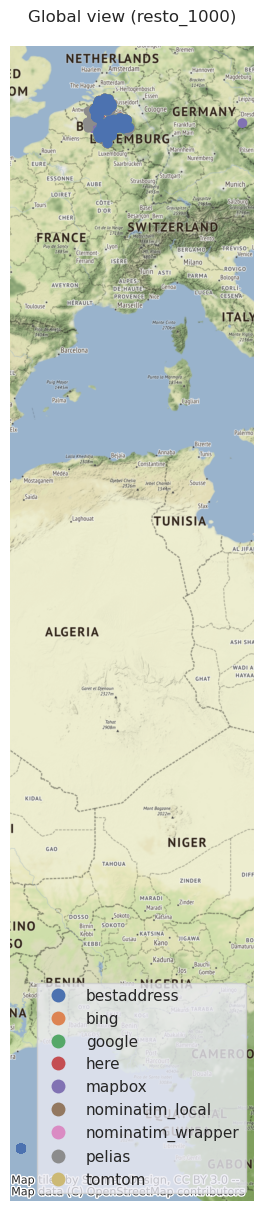

In [2421]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=(10,15), cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf.savefig( bbox_inches='tight')
# plt.show()
# plt.close()


In [2422]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [2423]:
# belgium_boundaries

In [2424]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.to_crs(crs).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).plot(ax=ax, color="red")
# plt.ylim([-10000000, 12000000])
# plt.axis("off")

In [2425]:
# ax = gpd.GeoSeries({"geometry": belgium_boundaries}).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).set_crs("EPSG:31370").to_crs(crs).plot(ax=ax, color="red")
# plt.axis("off")

In [2426]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     8625
False      79
Name: is_in_belgium, dtype: int64

In [2427]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder           is_in_belgium
bestaddress        True             764
                   False             78
bing               True             999
google             True             998
here               True             999
mapbox             True             999
                   False              1
nominatim_local    True             887
nominatim_wrapper  True             989
pelias             True             992
tomtom             True             998
Name: is_in_belgium, dtype: int64

In [2428]:
geocoded_data

street housenumber postcode  \
0                                            Rue Royale         135     1000   
1                                     Rue de Liboichant          44     5550   
2                                  Chaussée d'Alsemberg         741     1180   
3                                   Chaussée de Louvain         922     1140   
4                                    Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
8995                              Avenue Paul Deschanel          10     1030   
8996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
8997                                        Grote Markt          29     2800   
8998                                 Aarschotsesteenweg         201     2500   
8999                                     Hanswijkstraat          63     2800   

                  city                                            address  \
0     BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                 ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2                UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3                EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4                NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
8995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
8996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
8997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
8998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
8999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                               location           geocoder  \
0     (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_wrapper   
1     (44, Rue de Liboichant, Vresse-sur-Semois, Din...  nominatim_wrapper   
2     (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_wrapper   
3     (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_wrapper   
4     (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_wrapper   
...                                                 ...                ...   
8995  (Avenue Paul Deschanel, 10, 1030 Schaerbeek , ...        bestaddress   
8996  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...        bestaddress   
8997  (Grote Markt, 29, 2800 Malines , (51.027492847...        bestaddress   
8998  (Aarschotsesteenweg, 201, 2500 Lierre , (51.09...        bestaddress   
8999  (Hanswijkstraat, , 2800 Malines , (51.02258524...        bestaddress   

      duration precision                           point  is_in_belgium  
0     0.054017  building  POINT (485949.652 6595173.241)           True  
1     0.484434  building  POINT (553215.549 6420024.722)           True  
2     0.031772  building  POINT (482722.146 6586725.781)           True  
3     0.022083  building  POINT (491354.109 6596342.883)           True  
4     0.020958  building  POINT (541183.578 6527128.145)           True  
...        ...       ...                             ...            ...  
8995  0.300006  building  POINT (487705.732 6597013.529)           True  
8996  0.566713      city             POINT (0.000 0.000)          False  
8997  0.283218  building  POINT (498740.156 6626158.331)           True  
8998  0.316821  building  POINT (514459.781 6638252.044)           True  
8999  0.583195    street  POINT (499135.244 6625289.764)           True  

[8704 rows x 11 columns]

In [2429]:
geocoded_data[~geocoded_data.is_in_belgium]

street housenumber postcode  \
4975  Rue du Sourd d'Ave | situé au confins de la N9...           5     5580   
8013                                   Nijverheidstraat          13     2260   
8020                                avenue du Haut Pont           2     1060   
8050                             Boulevard E. Bockstael         201     1020   
8052                                 Chée. de Charleroi         197     1060   
...                                                 ...         ...      ...   
8919                               Avenue Charles Quint           7     1083   
8930                                    Rue des Moulins        9/11     4342   
8943                                Rue du Kasterlinden         198     1082   
8966                               Victor Hortaplein 22          22     1060   
8996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   

                       city  \
4975              ROCHEFORT   
8013               WESTERLO   
8020           SAINT-GILLES   
8050                 LAEKEN   
8052           SAINT-GILLES   
...                     ...   
8919              GANSHOREN   
8930                HOGNOUL   
8943  BERCHEM-SAINTE-AGATHE   
8966           SAINT-GILLES   
8996                IXELLES   

                                                address  \
4975  Rue du Sourd d'Ave | situé au confins de la N9...   
8013      Nijverheidstraat, 13, 2260 WESTERLO, Belgique   
8020  avenue du Haut Pont, 2, 1060 SAINT-GILLES, Bel...   
8050  Boulevard E. Bockstael, 201, 1020 LAEKEN, Belg...   
8052  Chée. de Charleroi, 197, 1060 SAINT-GILLES, Be...   
...                                                 ...   
8919  Avenue Charles Quint, 7, 1083 GANSHOREN, Belgique   
8930      Rue des Moulins, 9/11, 4342 HOGNOUL, Belgique   
8943  Rue du Kasterlinden, 198, 1082 BERCHEM-SAINTE-...   
8966  Victor Hortaplein 22, 22, 1060 SAINT-GILLES, B...   
8996  Boulevard du Triomphe Accès 4 de l'ULB (statio...   

                                               location     geocoder  \
4975  (Aue-Bad Schlema, Saxony, Germany, (50.586993,...       mapbox   
8013  (2260 Oevel/Tongerlo (Antw.)/Westerlo/Zoerle-P...  bestaddress   
8020                    (1060 Saint-Gilles, (0.0, 0.0))  bestaddress   
8050              (1020 Bruxelles (Laeken), (0.0, 0.0))  bestaddress   
8052                    (1060 Saint-Gilles, (0.0, 0.0))  bestaddress   
...                                                 ...          ...   
8919                       (1083 Ganshoren, (0.0, 0.0))  bestaddress   
8930  (Rue des Moulins, , 4342 Awans (Hognoul), (0.0...  bestaddress   
8943           (1082 Berchem-Sainte-Agathe, (0.0, 0.0))  bestaddress   
8966                    (1060 Saint-Gilles, (0.0, 0.0))  bestaddress   
8996  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...  bestaddress   

      duration  precision                            point  is_in_belgium  
4975  0.423961  [UNKNOWN]  POINT (1413676.159 6548560.180)          False  
8013  0.768802       city              POINT (0.000 0.000)          False  
8020  0.262719       city              POINT (0.000 0.000)          False  
8050  0.604025       city              POINT (0.000 0.000)          False  
8052  0.466070       city              POINT (0.000 0.000)          False  
...        ...        ...                              ...            ...  
8919  0.789588       city              POINT (0.000 0.000)          False  
8930  2.798142    country              POINT (0.000 0.000)          False  
8943  0.412028       city              POINT (0.000 0.000)          False  
8966  0.283347       city              POINT (0.000 0.000)          False  
8996  0.566713       city              POINT (0.000 0.000)          False  

[79 rows x 11 columns]

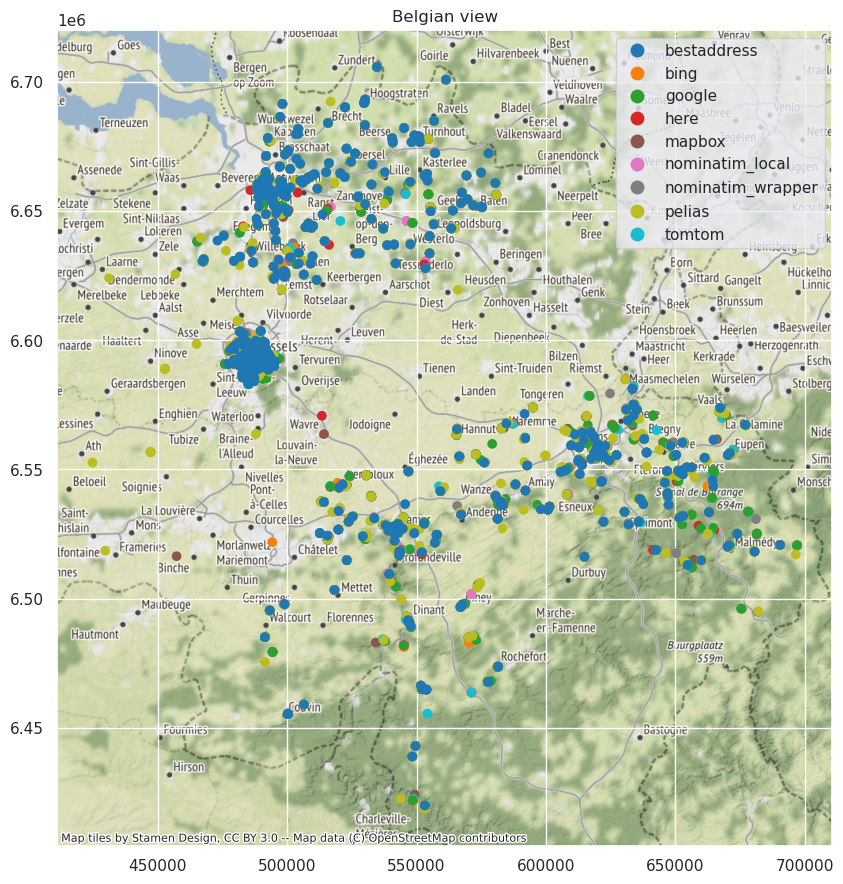

In [2430]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=(10,15))
plt.title("Belgian view")
add_basemap(ax)
# img_name=f"{fig_path}/belgium_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, width=240)
pdf.savefig(bbox_inches='tight')
# plt.show()
# plt.close()


## Compute (distance to) median

In [2431]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [2432]:
median_geocoders = ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

address  \
0     830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
1       AV scholgel 60, 60B, 5590 CHEVETOGNE, Belgique   
2        AVENUE DE FOREST, 2, 5580 ROCHEFORT, Belgique   
3         Aachener Strasse, 9, 4731 EYNATTEN, Belgique   
4         Aarschotsesteenweg, 201, 2500 LIER, Belgique   
..                                                 ...   
977      rue du Vieux Frêne, 3, 4100 SERAING, Belgique   
978  schttershofstraat, 11, 2000 ANVERS-CENTRE, Bel...   
979        turnhoutsebaan, 112, 2970 SCHILDE, Belgique   
980         warandestraat, 42, 2300 TURNHOUT, Belgique   
981    winston churchillaan, 259, 1180 UCCLE, Belgique   

                       median_point  nb_points  
0    POINT (547502.652 6518970.033)          5  
1    POINT (568708.736 6498015.915)          4  
2    POINT (581375.492 6473646.251)          7  
3    POINT (677178.913 6567227.494)          7  
4    POINT (514459.781 6638265.917)          7  
..                              ...        ...  
977  POINT (618040.254 6545050.954)          4  
978  POINT (490533.622 6659691.978)          4  
979  POINT (508127.834 6662897.132)          7  
980  POINT (550323.231 6678915.589)          7  
981  POINT (486195.462 6587940.229)          6  

[982 rows x 3 columns]

<Axes: ylabel='nb_points'>

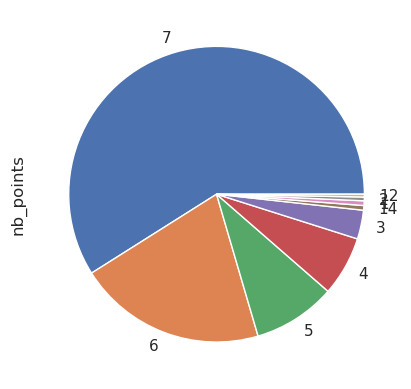

In [2433]:
median_points.nb_points.value_counts().plot.pie()

In [2434]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

(973, 3)

In [2435]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [2436]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

street housenumber postcode  \
3101                                           Closures           2     4960   
5805                                        Rue Griange           8     4500   
2654                       Square Jean Baptiste Degreef           7     1160   
2659                                      Rue de Dalhem          73     4600   
1876                                         Rue Royale         135     1000   
...                                                 ...         ...      ...   
8256                                         Rue Defack        [na]     1050   
8356                                  Heidestatiestraat        [na]     2920   
8444                                         Beukenlaan        [na]     2970   
8601                                    Place du Marché        [na]     4651   
8700  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   

                  city                                            address  \
3101           MALMEDY                Closures, 2, 4960 MALMEDY, Belgique   
5805               HUY                 Rue Griange, 8, 4500 HUY, Belgique   
2654         AUDERGHEM  Square Jean Baptiste Degreef, 7, 1160 AUDERGHE...   
2659              VISE             Rue de Dalhem, 73, 4600 VISE, Belgique   
1876  BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
...                ...                                                ...   
8256           IXELLES           Rue Defack, [na], 1050 IXELLES, Belgique   
8356         KALMTHOUT  Heidestatiestraat, [na], 2920 KALMTHOUT, Belgique   
8444           SCHILDE           Beukenlaan, [na], 2970 SCHILDE, Belgique   
8601           BATTICE      Place du Marché, [na], 4651 BATTICE, Belgique   
8700           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   

                                               location     geocoder  \
3101  (Les Closures 2, Malmedy, Walloon Region 4960,...         bing   
5805     (Rue Griange 8, 4500 Huy, (50.51762, 5.24141))       tomtom   
2654  (Square Jean-Baptiste de Greef 7, 1160 Audergh...         here   
2659  (Rue de Dalhem 73, 4600 Visé, Belgique, Visé, ...         here   
1876  (Rue Royale 135, 1000 Bruxelles, Belgique, Bru...         here   
...                                                 ...          ...   
8256  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...  bestaddress   
8356  (Heidestatiestraat, , 2920 Kalmthout , (51.366...  bestaddress   
8444  (Beukenlaan, , 2970 Schilde , (51.231085218, 4...  bestaddress   
8601  (Place du Marché, , 4651 Herve (Battice), (50....  bestaddress   
8700  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...  bestaddress   

      duration precision                           point  is_in_belgium  \
3101  0.191793  building  POINT (673966.280 6525143.815)           True   
5805  0.124575  building  POINT (583471.092 6536405.804)           True   
2654  0.049960  building  POINT (490754.202 6589619.320)           True   
2659  0.042957  building  POINT (635133.355 6573146.276)           True   
1876  0.290179  building  POINT (485949.652 6595173.506)           True   
...        ...       ...                             ...            ...   
8256  0.359049      city             POINT (0.000 0.000)          False   
8356  0.950041    street  POINT (497237.863 6686302.188)           True   
8444  0.399909    street  POINT (507570.903 6662272.267)           True   
8601  1.445770    street  POINT (648172.606 6559189.959)           True   
8700  0.566713      city             POINT (0.000 0.000)          False   

                        median_point  nb_points  dist_to_median  
3101  POINT (673966.280 6525143.815)        7.0             0.0  
5805  POINT (583471.092 6536405.804)        7.0             0.0  
2654  POINT (490754.202 6589619.320)        5.0             0.0  
2659  POINT (635133.355 6573146.276)        7.0             0.0  
1876  POINT (485949.652 6595173.506)        6.0             0.0  
.

In [2437]:
geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

street housenumber postcode           city  \
6565  Beukenlaan        [na]     2970        SCHILDE   
8444  Beukenlaan        [na]     2970        SCHILDE   
4569  Beukenlaan        [na]     2970        SCHILDE   
2570  Beukenlaan        [na]     2970        SCHILDE   
3570  Beukenlaan        [na]     2970        SCHILDE   
...          ...         ...      ...            ...   
3110        Ster         390     4970  FRANCORCHAMPS   
2111        Ster         390     4970  FRANCORCHAMPS   
7102        Ster         390     4970  FRANCORCHAMPS   
8059        Ster         390     4970  FRANCORCHAMPS   
5109        Ster         390     4970  FRANCORCHAMPS   

                                       address  \
6565  Beukenlaan, [na], 2970 SCHILDE, Belgique   
8444  Beukenlaan, [na], 2970 SCHILDE, Belgique   
4569  Beukenlaan, [na], 2970 SCHILDE, Belgique   
2570  Beukenlaan, [na], 2970 SCHILDE, Belgique   
3570  Beukenlaan, [na], 2970 SCHILDE, Belgique   
...                                        ...   
3110   Ster, 390, 4970 FRANCORCHAMPS, Belgique   
2111   Ster, 390, 4970 FRANCORCHAMPS, Belgique   
7102   Ster, 390, 4970 FRANCORCHAMPS, Belgique   
8059   Ster, 390, 4970 FRANCORCHAMPS, Belgique   
5109   Ster, 390, 4970 FRANCORCHAMPS, Belgique   

                                               location     geocoder  \
6565  (Beukenlaan, 2970 Schilde, Belgium, (51.230479...       google   
8444  (Beukenlaan, , 2970 Schilde , (51.231085218, 4...  bestaddress   
4569  (Beukenlaan, 2970 Schilde, Antwerp, Belgium, (...       mapbox   
2570  (Beukenlaan, 2970 Schilde, België, Schilde, Vl...         here   
3570  (Beukenlaan, Schilde, Flemish Region 2970, Bel...         bing   
...                                                 ...          ...   
3110  (Ster, Stavelot, Walloon Region 4970, Belgium,...         bing   
2111  (Ster, Stavelot, Wallonie, Belgique, Stavelot,...         here   
7102               (Francorchamps, (50.45353, 5.95276))       pelias   
8059  (Biester, , 4970 Stavelot (Stavelot), (50.3844...  bestaddress   
5109  (Route de Ster, 4970 Stavelot, (50.45523, 5.962))       tomtom   

      duration  precision                           point  is_in_belgium  \
6565  0.087642     street  POINT (507632.819 6662164.586)           True   
8444  0.399909     street  POINT (507570.903 6662272.267)           True   
4569  0.279569     street  POINT (507607.031 6662164.595)           True   
2570  0.070317     street  POINT (507634.689 6662175.341)           True   
3570  0.189223     street  POINT (507541.974 6662500.874)           True   
...        ...        ...                             ...            ...   
3110  0.247315     street  POINT (656924.930 6514523.002)           True   
2111  0.070350  [UNKNOWN]  POINT (665087.203 6526644.167)           True   
7102       NaN       city  POINT (662658.212 6525192.891)           True   
8059  2.728825     street  POINT (654744.856 6513117.625)           True   
5109  0.130588     street  POINT (663686.804 6525490.120)           True   

     median_point  nb_points  dist_to_median  
6565         None        NaN             NaN  
8444         None        NaN             NaN  
4569         None        NaN             NaN  
2570         None        NaN             NaN  
3570         None        NaN             NaN  
...           ...        ...             ...  
3110         None        NaN             NaN  
2111         None        NaN             NaN  
7102         None        NaN             NaN  
8059         None        NaN             NaN  
5109         None        NaN             NaN  

[144 rows x 14 columns]

In [2438]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [2439]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=(10,12)
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

street housenumber postcode    city  \
7     Rue Grande          91     5500  DINANT   
995   Rue Grande          91     5500  DINANT   
1883  Rue Grande          91     5500  DINANT   
2882  Rue Grande          91     5500  DINANT   
3881  Rue Grande          91     5500  DINANT   
4881  Rue Grande          91     5500  DINANT   
5879  Rue Grande          91     5500  DINANT   
6877  Rue Grande          91     5500  DINANT   
7869  Rue Grande          91     5500  DINANT   

                                    address  \
7     Rue Grande, 91, 5500 DINANT, Belgique   
995   Rue Grande, 91, 5500 DINANT, Belgique   
1883  Rue Grande, 91, 5500 DINANT, Belgique   
2882  Rue Grande, 91, 5500 DINANT, Belgique   
3881  Rue Grande, 91, 5500 DINANT, Belgique   
4881  Rue Grande, 91, 5500 DINANT, Belgique   
5879  Rue Grande, 91, 5500 DINANT, Belgique   
6877  Rue Grande, 91, 5500 DINANT, Belgique   
7869  Rue Grande, 91, 5500 DINANT, Belgique   

                                               location           geocoder  \
7     (91, Rue Grande, Neffe, Dinant, Namur, Walloni...  nominatim_wrapper   
995   (91, Rue Grande, Neffe, Dinant, Namur, Walloni...    nominatim_local   
1883  (Rue Grande 91, 5500 Dinant, Belgique, Dinant,...               here   
2882  (Rue Grande 91, Dinant, Walloon Region 5500, B...               bing   
3881  (Rue Grande 91, 5500 Dinant, Namur, Belgium, (...             mapbox   
4881  (Rue Grande 91, 5500 Dinant, (50.25846, 4.91422))             tomtom   
5879  (Rue Grande 91, 5500 Dinant, Belgium, (50.2584...             google   
6877               (Rue Grande 91, (50.25846, 4.91422))             pelias   
7869  (Rue Grande, 91, 5500 Dinant (Dinant), (50.258...        bestaddress   

      duration precision                           point  is_in_belgium  \
7     0.214689  building  POINT (547048.175 6491157.462)           True   
995   0.013257  building  POINT (547048.175 6491157.462)           True   
1883  0.043674  building  POINT (547048.468 6491157.462)           True   
2882  0.260400  building  POINT (547048.279 6491157.532)           True   
3881  0.159998  building  POINT (547048.245 6491157.462)           True   
4881  0.133092  building  POINT (547048.468 6491157.462)           True   
5879  0.127952  building  POINT (547044.416 6491158.246)           True   
6877       NaN  building  POINT (547048.468 6491157.462)           True   
7869  0.317978  building  POINT (547048.246 6491157.468)           True   

                        median_point  nb_points  dist_to_median  
7     POINT (547048.246 6491157.462)        7.0        0.070533  
995   POINT (547048.246 6491157.462)        7.0        0.070533  
1883  POINT (547048.246 6491157.462)        7.0        0.222194  
2882  POINT (547048.246 6491157.462)        7.0        0.077049  
3881  POINT (547048.246 6491157.462)        7.0        0.000445  
4881  POINT (547048.246 6491157.462)        7.0        0.222194  
5879  POINT (547048.246 6491157.462)        7.0        3.909166  
6877  POINT (547048.246 6491157.462)        7.0        0.222194  
7869  POINT (547048.246 6491157.462)        7.0        0.006268

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 18).

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).



Default basemap doesn't work...


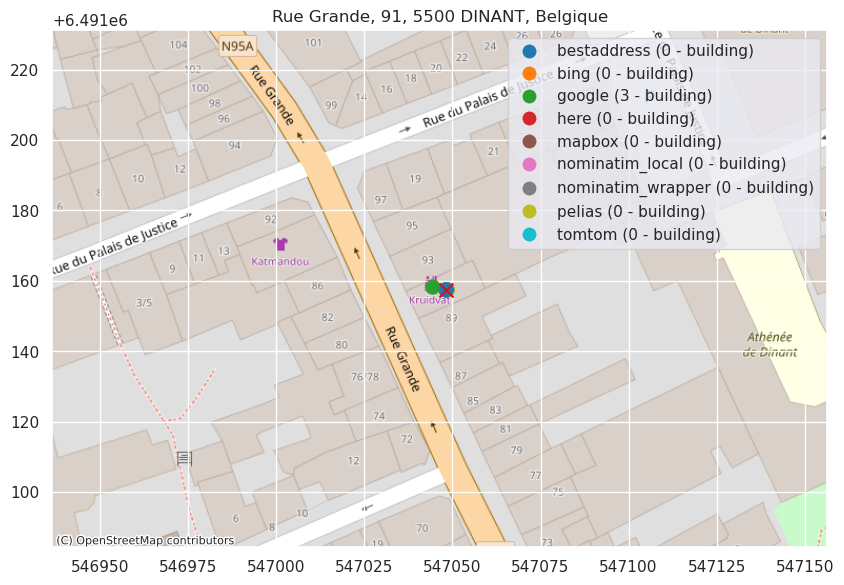

<Axes: title={'center': 'Rue Grande, 91, 5500 DINANT, Belgique'}>

In [2440]:
plot_address(geocoded_data, geocoded_data.iloc[7].address)

street housenumber postcode          city  \
703    Dopr           9     2360  OUD-TURNHOUT   
2586   Dopr           9     2360  OUD-TURNHOUT   
3586   Dopr           9     2360  OUD-TURNHOUT   
4585   Dopr           9     2360  OUD-TURNHOUT   
5583   Dopr           9     2360  OUD-TURNHOUT   
6581   Dopr           9     2360  OUD-TURNHOUT   
7574   Dopr           9     2360  OUD-TURNHOUT   
8458   Dopr           9     2360  OUD-TURNHOUT   

                                   address  \
703   Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
2586  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
3586  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
4585  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
5583  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
6581  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
7574  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   
8458  Dopr, 9, 2360 OUD-TURNHOUT, Belgique   

                                               location           geocoder  \
703   (9, Dorp, Oud-Turnhout, Turnhout, Antwerpen, V...  nominatim_wrapper   
2586  (Dorp 9, 2360 Oud-Turnhout, België, Oud-Turnho...               here   
3586  (Steenweg op Turnhout 9, Oud-Turnhout, Flemish...               bing   
4585  (Dorp 9, 2360 Oud-Turnhout, Antwerp, Belgium, ...             mapbox   
5583   (Dorp 9, 2360 Oud-Turnhout, (51.31819, 4.98072))             tomtom   
6581  (Dorp 9, 2360 Oud-Turnhout, Belgium, (51.31821...             google   
7574              (Oud-Turnhout, (51.318313, 4.981055))             pelias   
8458                    (2360 Oud-Turnhout, (0.0, 0.0))        bestaddress   

      duration precision                           point  is_in_belgium  \
703   0.409729  building  POINT (554450.690 6677771.518)           True   
2586  0.057671  building  POINT (554450.101 6677772.025)           True   
3586  0.212102  building  POINT (554357.071 6677830.625)           True   
4585  0.157289  building  POINT (554450.658 6677771.491)           True   
5583  0.171441  building  POINT (554451.214 6677772.025)           True   
6581  0.102292  building  POINT (554441.518 6677776.924)           True   
7574       NaN      city  POINT (554488.506 6677793.933)           True   
8458  0.233887      city             POINT (0.000 0.000)          False   

                        median_point  nb_points  dist_to_median  
703   POINT (554450.379 6677772.025)        6.0    5.952996e-01  
2586  POINT (554450.379 6677772.025)        6.0    2.782987e-01  
3586  POINT (554450.379 6677772.025)        6.0    1.101828e+02  
4585  POINT (554450.379 6677772.025)        6.0    6.024676e-01  
5583  POINT (554450.379 6677772.025)        6.0    8.348962e-01  
6581  POINT (554450.379 6677772.025)        6.0    1.012469e+01  
7574  POINT (554450.379 6677772.025)        6.0    4.397292e+01  
8458  POINT (554450.379 6677772.025)        6.0    6.700750e+06

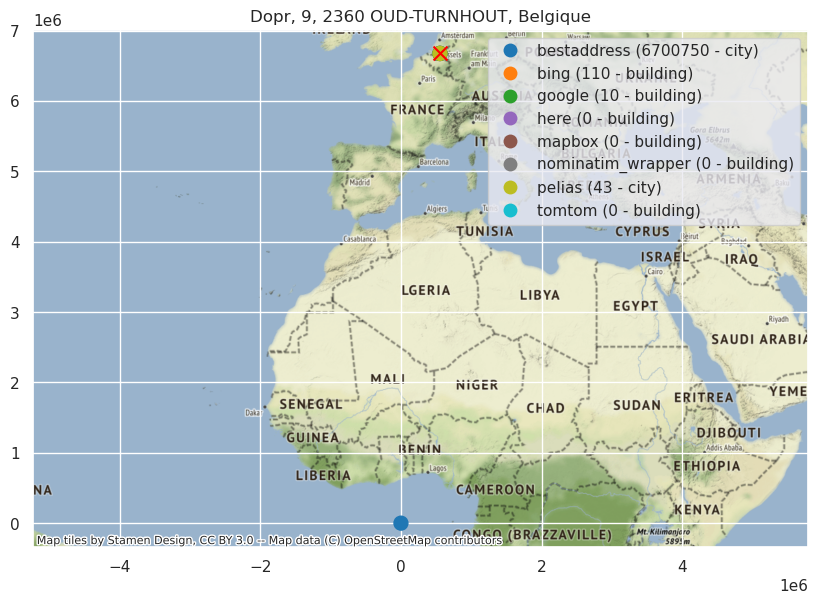

street housenumber postcode      city  \
243   Anrwerpsesteenweg          41     2950  KAPELLEN   
2123  Anrwerpsesteenweg          41     2950  KAPELLEN   
3122  Anrwerpsesteenweg          41     2950  KAPELLEN   
4121  Anrwerpsesteenweg          41     2950  KAPELLEN   
5121  Anrwerpsesteenweg          41     2950  KAPELLEN   
6119  Anrwerpsesteenweg          41     2950  KAPELLEN   
7114  Anrwerpsesteenweg          41     2950  KAPELLEN   
8069  Anrwerpsesteenweg          41     2950  KAPELLEN   

                                             address  \
243   Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
2123  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
3122  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
4121  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
5121  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
6119  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
7114  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   
8069  Anrwerpsesteenweg, 41, 2950 KAPELLEN, Belgique   

                                               location           geocoder  \
243   (41, Antwerpsesteenweg, Essenhout, Kapellen, A...  nominatim_wrapper   
2123  (Antwerpsesteenweg 41, 2950 Kapellen, België, ...               here   
3122  (Antwerpsesteenweg 41, Kapellen, Flemish Regio...               bing   
4121  (Antwerpsesteenweg 41, 2950 Kapellen, Antwerp,...             mapbox   
5121  (Antwerpsesteenweg 41, 2950 Kapellen, (51.3130...             tomtom   
6119  (Antwerpsesteenweg 41, 2950 Kapellen, Belgium,...             google   
7114                    (Kapellen, (51.31377, 4.43539))             pelias   
8069                (2950 Kapellen (Antw.), (0.0, 0.0))        bestaddress   

      duration precision                           point  is_in_belgium  \
243   0.386444  building  POINT (493069.637 6676847.611)           True   
2123  0.080921  building  POINT (493077.439 6676851.235)           True   
3122  0.194735  building  POINT (493078.285 6676850.718)           True   
4121  0.143394  building  POINT (493073.543 6676848.920)           True   
5121  0.132543  building  POINT (493078.553 6676851.235)           True   
6119  0.088385  building  POINT (493066.697 6676847.531)           True   
7114       NaN      city  POINT (493745.356 6676984.805)           True   
8069  1.138901      city             POINT (0.000 0.000)          False   

                        median_point  nb_points  dist_to_median  
243   POINT (493075.491 6676849.819)        6.0    6.257247e+00  
2123  POINT (493075.491 6676849.819)        6.0    2.408246e+00  
3122  POINT (493075.491 6676849.819)        6.0    2.935296e+00  
4121  POINT (493075.491 6676849.819)        6.0    2.145675e+00  
5121  POINT (493075.491 6676849.819)        6.0    3.372842e+00  
6119  POINT (493075.491 6676849.819)        6.0    9.087125e+00  
7114  POINT (493075.491 6676849.819)        6.0    6.833304e+02  
8069  POINT (493075.491 6676849.819)        6.0    6.695032e+06

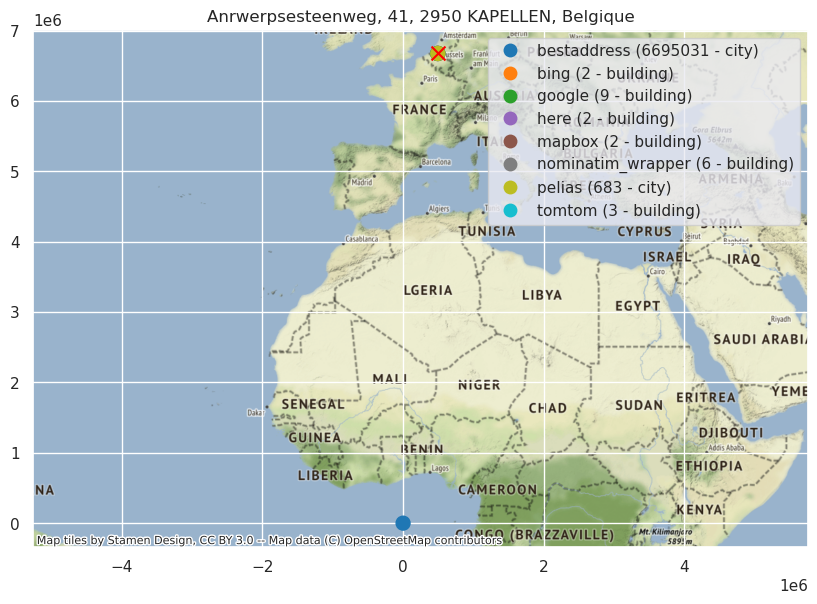

street housenumber postcode city  \
438   Sint-Jozefslaan          79     2400  MOL   
1382  Sint-Jozefslaan          79     2400  MOL   
2320  Sint-Jozefslaan          79     2400  MOL   
3319  Sint-Jozefslaan          79     2400  MOL   
4318  Sint-Jozefslaan          79     2400  MOL   
5318  Sint-Jozefslaan          79     2400  MOL   
6315  Sint-Jozefslaan          79     2400  MOL   
7310  Sint-Jozefslaan          79     2400  MOL   
8235  Sint-Jozefslaan          79     2400  MOL   

                                      address  \
438   Sint-Jozefslaan, 79, 2400 MOL, Belgique   
1382  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
2320  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
3319  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
4318  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
5318  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
6315  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
7310  Sint-Jozefslaan, 79, 2400 MOL, Belgique   
8235  Sint-Jozefslaan, 79, 2400 MOL, Belgique   

                                               location           geocoder  \
438   (Hippocampus, 79, Sint-Jozefslaan, Wezel, Mol,...  nominatim_wrapper   
1382  (Hippocampus, 79, Sint-Jozefslaan, Wezel, Mol,...    nominatim_local   
2320  (St.-Jozefslaan 79, 2400 Mol, België, Mol, Vla...               here   
3319  (Sint-Jozefslaan 79, Mol, Flemish Region 2400,...               bing   
4318  (Sint-Jozefslaan 79, 2400 Mol, Antwerp, Belgiu...             mapbox   
5318  (Sint-Jozefslaan 79, 2400 Mol, (51.19628, 5.21...             tomtom   
6315  (Sint-Jozefslaan 79, 2400 Mol, Belgium, (51.19...             google   
7310          (Sint-Jozefslaan 79, (51.19633, 5.21772))             pelias   
8235                             (2400 Mol, (0.0, 0.0))        bestaddress   

      duration precision                           point  is_in_belgium  \
438   0.092046  building  POINT (580835.459 6656092.942)           True   
1382  0.010718  building  POINT (580835.459 6656092.942)           True   
2320  0.072455  building  POINT (580833.934 6656095.980)           True   
3319  0.200761  building  POINT (580788.203 6656086.778)           True   
4318  0.172885  building  POINT (580834.601 6656095.624)           True   
5318  0.100345  building  POINT (580788.293 6656087.098)           True   
6315  0.091341  building  POINT (580836.015 6656098.271)           True   
7310       NaN    street  POINT (580833.934 6656095.980)           True   
8235  0.320010      city             POINT (0.000 0.000)          False   

                        median_point  nb_points  dist_to_median  
438   POINT (580834.267 6656094.283)        6.0    1.793754e+00  
1382  POINT (580834.267 6656094.283)        6.0    1.793754e+00  
2320  POINT (580834.267 6656094.283)        6.0    1.729031e+00  
3319  POINT (580834.267 6656094.283)        6.0    4.667143e+01  
4318  POINT (580834.267 6656094.283)        6.0    1.382143e+00  
5318  POINT (580834.267 6656094.283)        6.0    4.653309e+01  
6315  POINT (580834.267 6656094.283)        6.0    4.354194e+00  
7310  POINT (580834.267 6656094.283)        6.0    1.729031e+00  
8235  POINT (580834.267 6656094.283)        6.0    6.681389e+06

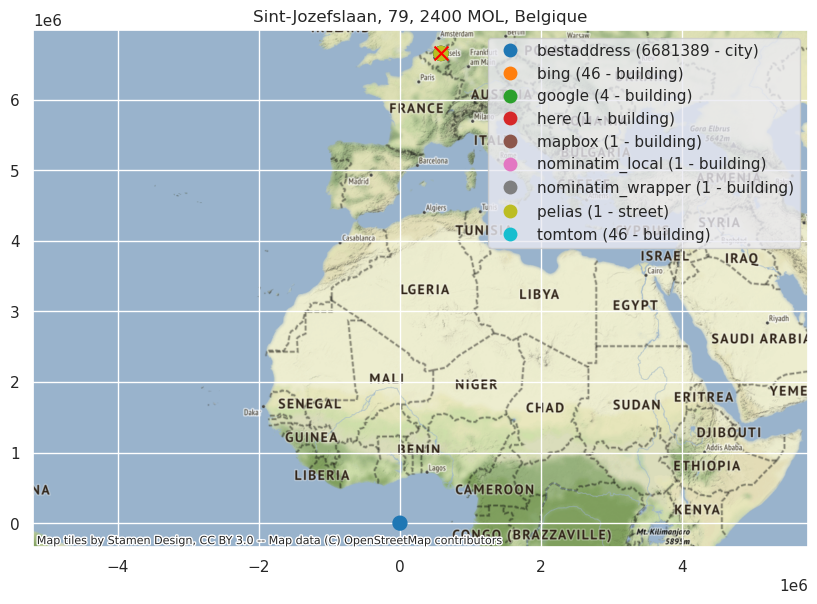

street housenumber postcode  city  \
697   Dokter Van De Perrestraat        443a     2440  GEEL   
1608  Dokter Van De Perrestraat        443a     2440  GEEL   
2580  Dokter Van De Perrestraat        443a     2440  GEEL   
3580  Dokter Van De Perrestraat        443a     2440  GEEL   
4579  Dokter Van De Perrestraat        443a     2440  GEEL   
5577  Dokter Van De Perrestraat        443a     2440  GEEL   
6575  Dokter Van De Perrestraat        443a     2440  GEEL   
7568  Dokter Van De Perrestraat        443a     2440  GEEL   
8453  Dokter Van De Perrestraat        443a     2440  GEEL   

                                                address  \
697   Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
1608  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
2580  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
3580  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
4579  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
5577  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
6575  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
7568  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   
8453  Dokter Van De Perrestraat, 443a, 2440 GEEL, Be...   

                                               location           geocoder  \
697   (443;443A, Dr.-Van de Perrestraat, Ten Aard, G...  nominatim_wrapper   
1608  (443;443A, Dr.-Van de Perrestraat, Ten Aard, G...    nominatim_local   
2580  (Dr. Van de Perrestraat 443A, 2440 Geel, Belgi...               here   
3580  (Dokter Van de Perrestraat 443A, Geel, Flemish...               bing   
4579  (Dokter Van De Perrestraat 443a, 2440 Geel, An...             mapbox   
5577  (Dokter Van de Perrestraat 443A, 2440 Geel, (5...             tomtom   
6575  (Dr.-Van de Perrestraat 443a, 2440 Geel, Belgi...             google   
7568                      (Geel, (51.163377, 4.990481))             pelias   
8453                            (2440 Geel, (0.0, 0.0))        bestaddress   

      duration precision                           point  is_in_belgium  \
697   0.023639  building  POINT (554580.718 6656399.983)           True   
1608  0.012287  building  POINT (554580.718 6656399.983)           True   
2580  0.085029  building  POINT (554578.118 6656406.858)           True   
3580  0.211162  building  POINT (554578.764 6656407.213)           True   
4579  0.188823  building  POINT (554579.343 6656403.660)           True   
5577  0.228645  building  POINT (554579.232 6656406.858)           True   
6575  0.114082  building  POINT (554576.838 6656399.734)           True   
7568       NaN      city  POINT (555537.804 6650244.263)           True   
8453  0.249863      city             POINT (0.000 0.000)          False   

                        median_point  nb_points  dist_to_median  
697   POINT (554578.998 6656405.259)        6.0    5.549612e+00  
1608  POINT (554578.998 6656405.259)        6.0    5.549612e+00  
2580  POINT (554578.998 6656405.259)        6.0    1.824732e+00  
3580  POINT (554578.998 6656405.259)        6.0    1.968060e+00  
4579  POINT (554578.998 6656405.259)        6.0    1.635649e+00  
5577  POINT (554578.998 6656405.259)        6.0    1.615831e+00  
6575  POINT (554578.998 6656405.259)        6.0    5.931930e+00  
7568  POINT (554578.998 6656405.259)        6.0    6.235157e+03  
8453  POINT (554578.998 6656405.259)        6.0    6.679468e+06

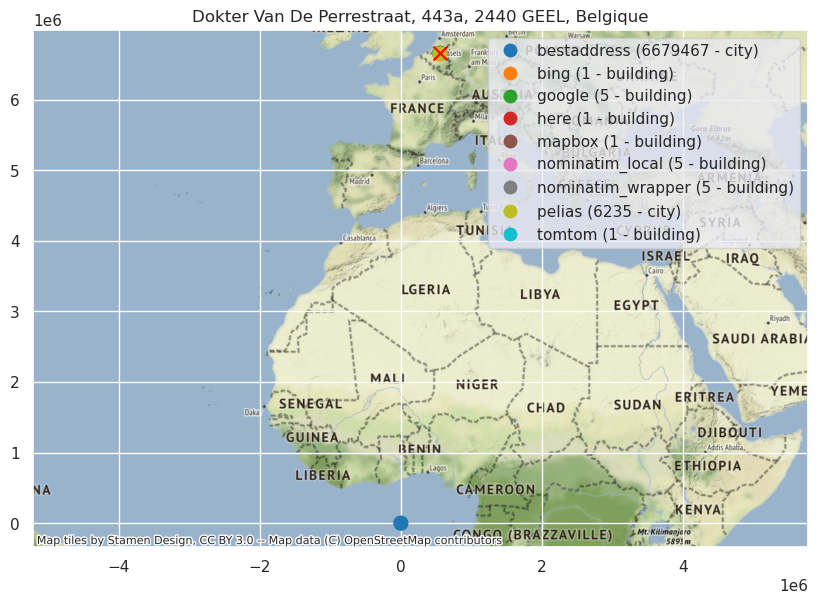

street housenumber postcode       city  \
871   Olsensteenweg        40 A     2460  LICHTAART   
2755  Olsensteenweg        40 A     2460  LICHTAART   
3754  Olsensteenweg        40 A     2460  LICHTAART   
4754  Olsensteenweg        40 A     2460  LICHTAART   
5752  Olsensteenweg        40 A     2460  LICHTAART   
6750  Olsensteenweg        40 A     2460  LICHTAART   
7742  Olsensteenweg        40 A     2460  LICHTAART   
8603  Olsensteenweg        40 A     2460  LICHTAART   

                                            address  \
871   Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
2755  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
3754  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
4754  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
5752  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
6750  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
7742  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   
8603  Olsensteenweg, 40 A, 2460 LICHTAART, Belgique   

                                               location           geocoder  \
871   (40, Olensteenweg, Lichtaart, Kasterlee, Turnh...  nominatim_wrapper   
2755  (Lichtaart, Kasterlee, Vlaanderen, België, Kas...               here   
3754  (Olensteenweg 40, Kasterlee, Flemish Region 24...               bing   
4754  (Olensteenweg 40, 2460 Kasterlee, Antwerp, Bel...             mapbox   
5752  (Olensteenweg 40, 2460 Kasterlee, (51.19889, 4...             tomtom   
6750  (Lichtaart, 2460 Kasterlee, Belgium, (51.21972...             google   
7742                  (Lichtaart, (51.220362, 4.91752))             pelias   
8603      (2460 Kasterlee/Lichtaart/Tielen, (0.0, 0.0))        bestaddress   

      duration  precision                           point  is_in_belgium  \
871   0.450823   building  POINT (545717.160 6656551.562)           True   
2755  0.067657  [UNKNOWN]  POINT (547752.007 6661122.992)           True   
3754  0.206633   building  POINT (545730.167 6656551.304)           True   
4754  0.153833   building  POINT (545557.121 6656809.773)           True   
5752  0.210118   building  POINT (545730.445 6656550.754)           True   
6750  0.087774       city  POINT (546668.735 6660252.968)           True   
7742       NaN       city  POINT (547415.822 6660366.166)           True   
8603  0.414509       city             POINT (0.000 0.000)          False   

                        median_point  nb_points  dist_to_median  
871   POINT (545723.663 6656551.433)        4.0    6.504797e+00  
2755  POINT (545723.663 6656551.433)        4.0    5.001332e+03  
3754  POINT (545723.663 6656551.433)        4.0    6.504797e+00  
4754  POINT (545723.663 6656551.433)        4.0    3.073693e+02  
5752  POINT (545723.663 6656551.433)        4.0    6.815778e+00  
6750  POINT (545723.663 6656551.433)        4.0    3.820277e+03  
7742  POINT (545723.663 6656551.433)        4.0    4.173199e+03  
8603  POINT (545723.663 6656551.433)        4.0    6.678884e+06

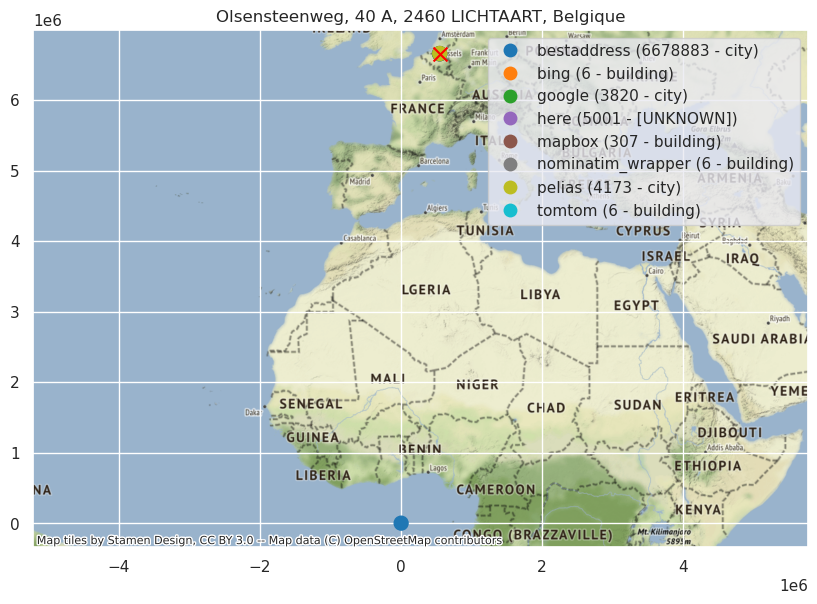

In [2441]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

In [2442]:
# geocoders["bing"].geocode("Rue Le Lorrain, 4, 1080 Molenbeek-Saint-Jean, Belgique")

In [2443]:
# geocoded_data.loc[25].location.raw

## Median pertinence

How many close to median ?

In [2444]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()

nb_close_to_median

address
830 Nationale | Naninne, 4, 5100 NAMUR, Belgique       0
AV scholgel 60, 60B, 5590 CHEVETOGNE, Belgique         4
AVENUE DE FOREST, 2, 5580 ROCHEFORT, Belgique          9
Aachener Strasse, 9, 4731 EYNATTEN, Belgique           8
Aarschotsesteenweg, 201, 2500 LIER, Belgique           7
                                                      ..
rue du Vieux Frêne, 3, 4100 SERAING, Belgique          7
schttershofstraat, 11, 2000 ANVERS-CENTRE, Belgique    4
turnhoutsebaan, 112, 2970 SCHILDE, Belgique            9
warandestraat, 42, 2300 TURNHOUT, Belgique             9
winston churchillaan, 259, 1180 UCCLE, Belgique        5
Name: close_to_median, Length: 992, dtype: int64

In [2445]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [2446]:
median_points.nb_close_to_median.value_counts()

8     331
9     301
7     120
6      82
5      57
4      38
3      19
2       9
0       6
18      4
16      4
1       2
Name: nb_close_to_median, dtype: int64

In [2447]:
median_points[median_points.nb_close_to_median>=2]

address  \
1       AV scholgel 60, 60B, 5590 CHEVETOGNE, Belgique   
2        AVENUE DE FOREST, 2, 5580 ROCHEFORT, Belgique   
3         Aachener Strasse, 9, 4731 EYNATTEN, Belgique   
4         Aarschotsesteenweg, 201, 2500 LIER, Belgique   
5           Aarschotsesteenweg, 3, 2500 LIER, Belgique   
..                                                 ...   
968      rue du Vieux Frêne, 3, 4100 SERAING, Belgique   
969  schttershofstraat, 11, 2000 ANVERS-CENTRE, Bel...   
970        turnhoutsebaan, 112, 2970 SCHILDE, Belgique   
971         warandestraat, 42, 2300 TURNHOUT, Belgique   
972    winston churchillaan, 259, 1180 UCCLE, Belgique   

                       median_point  nb_points  nb_close_to_median  
1    POINT (568708.736 6498015.915)          4                   4  
2    POINT (581375.492 6473646.251)          7                   9  
3    POINT (677178.913 6567227.494)          7                   8  
4    POINT (514459.781 6638265.917)          7                   7  
5    POINT (509386.589 6643438.179)          7                   8  
..                              ...        ...                 ...  
968  POINT (618040.254 6545050.954)          4                   7  
969  POINT (490533.622 6659691.978)          4                   4  
970  POINT (508127.834 6662897.132)          7                   9  
971  POINT (550323.231 6678915.589)          7                   9  
972  POINT (486195.462 6587940.229)          6                   5  

[965 rows x 4 columns]

In [2448]:
nb_close_to_median.value_counts()

8     331
9     301
7     120
6      82
5      57
4      38
0      25
3      19
2       9
18      4
16      4
1       2
Name: close_to_median, dtype: int64

In [2449]:
geocoded_data = geocoded_data.merge(median_points, how="left")


In [2450]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [2451]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

965

street housenumber postcode   city  \
883   830 Nationale | Naninne           4     5100  NAMUR   
1777  830 Nationale | Naninne           4     5100  NAMUR   
2767  830 Nationale | Naninne           4     5100  NAMUR   
3766  830 Nationale | Naninne           4     5100  NAMUR   
4766  830 Nationale | Naninne           4     5100  NAMUR   
5764  830 Nationale | Naninne           4     5100  NAMUR   
6762  830 Nationale | Naninne           4     5100  NAMUR   
7754  830 Nationale | Naninne           4     5100  NAMUR   

                                               address  \
883   830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
1777  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
2767  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
3766  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
4766  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
5764  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
6762  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
7754  830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   

                                               location           geocoder  \
883   (Chaussée Nationale 4, Naninne, Sart-Bernard, ...  nominatim_wrapper   
1777  (Chaussée Nationale 4, Naninne, Sart-Bernard, ...    nominatim_local   
2767  (Chaussée Nationale 4 4, 5330 Assesse, Belgiqu...               here   
3766  (Cité du Parc de Naninne 4, Namur, Walloon Reg...               bing   
4766  (Rue De Naninne 4, 5100 Namur, Namur, Belgium,...             mapbox   
5764  (Cité du Parc de Naninne 4, 5100 Namur, (50.41...             tomtom   
6762  (Rue de Naninne 4, 5100 Namur, Belgium, (50.41...             google   
7754                     (Namur, (50.465055, 4.859976))             pelias   

      duration precision                           point  is_in_belgium  \
883   0.043579    street  POINT (550441.675 6518684.359)           True   
1777  0.030582    street  POINT (550441.675 6518684.359)           True   
2767  0.078739  building  POINT (552038.921 6517178.742)           True   
3766  0.209537  building  POINT (547502.863 6519204.614)           True   
4766  0.170436  building  POINT (544081.915 6518925.780)           True   
5764  0.180349  building  POINT (547502.652 6519205.138)           True   
6762  0.102664  building  POINT (547230.475 6518970.033)           True   
7754       NaN      city  POINT (541010.054 6527208.135)           True   

                        median_point  nb_points  dist_to_median  \
883   POINT (547502.652 6518970.033)        5.0             NaN   
1777  POINT (547502.652 6518970.033)        5.0             NaN   
2767  POINT (547502.652 6518970.033)        5.0             NaN   
3766  POINT (547502.652 6518970.033)        5.0             NaN   
4766  POINT (547502.652 6518970.033)        5.0             NaN   
5764  POINT (547502.652 6518970.033)        5.0             NaN   
6762  POINT (547502.652 6518970.033)        5.0             NaN   
7754  POINT (547502.652 6518970.033)        5.0             NaN   

      nb_close_to_median  
883                  0.0  
1777                 0.0  
2767                 0.0  
3766                 0.0  
4766                 0.0  
5764                 0.0  
6762                 0.0  
7754                 0.0

No median point


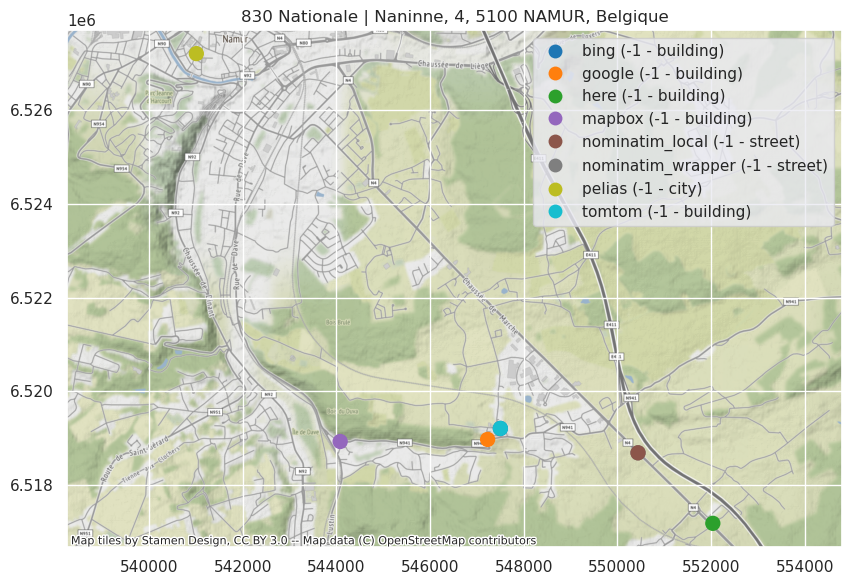

In [2452]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:10].index:
    #print(a)
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)
  

# Statistics

In [2453]:
# geocoded_data


## Add selectors

In [2454]:
geocoded_data["has_median"] = geocoded_data.dist_to_median.notnull()
geocoded_data["has_median"].value_counts()

True     8500
False     204
Name: has_median, dtype: int64

In [2455]:
geocoded_data[geocoded_data["has_median"]].address.nunique()

965

In [2456]:
# geocoded_data["is_median_reliable"] =   geocoded_data["nb_close_to_median"]>=2
# geocoded_data.is_median_reliable.value_counts()

In [2457]:
geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.995)
geocoded_data.is_value_normal.value_counts() # / geocoded_data.shape[0]

True     8457
False     247
Name: is_value_normal, dtype: int64

In [2458]:
geocoded_data["less_than_10km"]    = geocoded_data.dist_to_median < 10000
geocoded_data.less_than_10km.value_counts() # / geocoded_data.shape[0]

True     8286
False     418
Name: less_than_10km, dtype: int64

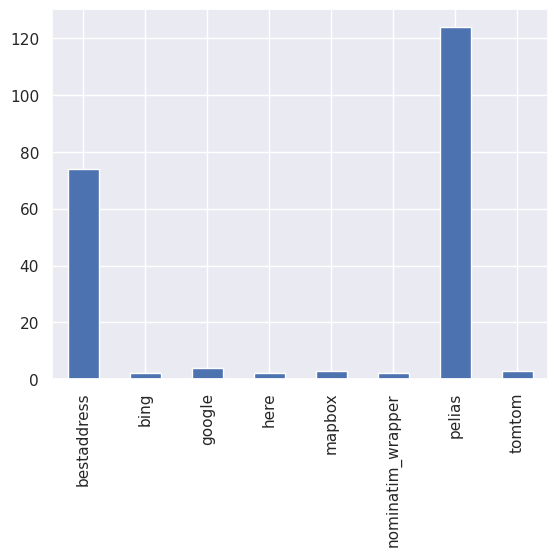

In [2459]:
vc = geocoded_data[(geocoded_data.dist_to_median > 10000)].geocoder.value_counts().sort_index()
if vc.shape[0]>0:
    vc.plot.bar()

In [2460]:
geocoded_data.dist_to_median.quantile(0.99)

85831.84654274886

In [2461]:
pd.crosstab(geocoded_data.is_value_normal, geocoded_data.is_in_belgium)

is_in_belgium    False  True 
is_value_normal              
False               47    200
True                32   8425

In [2462]:
#Q3 + (Q3-Q1 = IQR) * 1.5 
top_whisker = geocoded_data.dist_to_median.quantile(0.75) + (geocoded_data.dist_to_median.quantile(0.75) - geocoded_data.dist_to_median.quantile(0.25))*1.5
geocoded_data["is_below_top_whisker"]    = geocoded_data.dist_to_median < top_whisker
geocoded_data.is_below_top_whisker.value_counts()

True     6889
False    1815
Name: is_below_top_whisker, dtype: int64

In [2463]:
geocoded_data.dist_to_median.quantile(0.75) 

10.019886215245123

In [2464]:
# geocoded_data[geocoded_data.is_below_top_whisker].dist_to_median.hist(bins=100)

In [2465]:
top_whisker

24.560964735194467

In [2466]:
# geocoded_data[~geocoded_data.is_below_top_whisker]

In [2467]:
geocoded_data.dist_to_median.quantile(0.99)

85831.84654274886

In [2468]:
# match_per_addr = geocoded_data.groupby("address").geocoder.count()
# geocoded_data["has_enough_matches"] = geocoded_data.address.isin(match_per_addr[match_per_addr>=3].index)
# geocoded_data["has_enough_matches"].value_counts()

In [2469]:
# pd.crosstab(geocoded_data["is_median_reliable"] , geocoded_data["has_enough_matches"])

In [2470]:
geocoded_data["is_reliable"] = geocoded_data["is_value_normal"] & \
                               geocoded_data["is_in_belgium"]

#geocoded_data["is_median_reliable"] & \
                               #geocoded_data["has_enough_matches"] &  \

<Axes: >

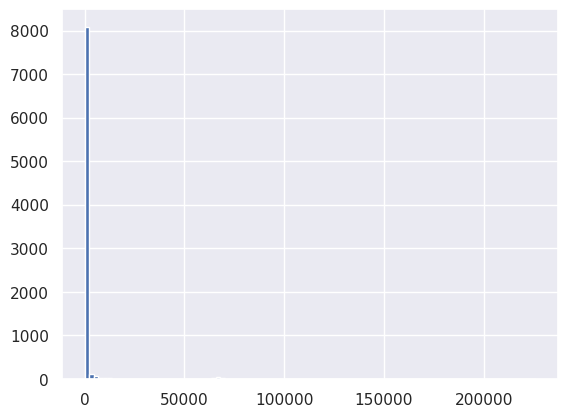

In [2471]:
geocoded_data[geocoded_data.is_reliable].dist_to_median.hist(bins=100)

In [2472]:
# pd.crosstab(geocoded_data["is_in_belgium"] , geocoded_data["is_value_normal"])

In [2473]:
# match_per_addr.value_counts().plot.bar()

In [2474]:
geocoded_data[~geocoded_data.is_value_normal].geocoder.value_counts()

bestaddress          55
bing                 27
mapbox               27
google               27
here                 26
pelias               26
tomtom               25
nominatim_wrapper    24
nominatim_local      10
Name: geocoder, dtype: int64

In [2475]:
geocoded_data

street housenumber postcode  \
0                                            Rue Royale         135     1000   
1                                     Rue de Liboichant          44     5550   
2                                  Chaussée d'Alsemberg         741     1180   
3                                   Chaussée de Louvain         922     1140   
4                                    Rue Basse Marcelle          26     5000   
...                                                 ...         ...      ...   
8699                              Avenue Paul Deschanel          10     1030   
8700  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
8701                                        Grote Markt          29     2800   
8702                                 Aarschotsesteenweg         201     2500   
8703                                     Hanswijkstraat          63     2800   

                  city                                            address  \
0     BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique   
1                 ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique   
2                UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique   
3                EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique   
4                NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique   
...                ...                                                ...   
8699        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...   
8700           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...   
8701           MALINES            Grote Markt, 29, 2800 MALINES, Belgique   
8702              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique   
8703           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique   

                                               location           geocoder  \
0     (135, Rue Royale - Koningsstraat, Bruxelles - ...  nominatim_wrapper   
1     (44, Rue de Liboichant, Vresse-sur-Semois, Din...  nominatim_wrapper   
2     (741, Chaussée d'Alsemberg - Alsembergsesteenw...  nominatim_wrapper   
3     (Chez Anesti, 922, Chaussée de Louvain - Leuve...  nominatim_wrapper   
4     (Le Bistronome, 26, Rue Basse Marcelle, Bomel,...  nominatim_wrapper   
...                                                 ...                ...   
8699  (Avenue Paul Deschanel, 10, 1030 Schaerbeek , ...        bestaddress   
8700  (1050 Ixelles + Bruxelles (Louise-Roosevelt), ...        bestaddress   
8701  (Grote Markt, 29, 2800 Malines , (51.027492847...        bestaddress   
8702  (Aarschotsesteenweg, 201, 2500 Lierre , (51.09...        bestaddress   
8703  (Hanswijkstraat, , 2800 Malines , (51.02258524...        bestaddress   

      duration precision                           point  is_in_belgium  \
0     0.054017  building  POINT (485949.652 6595173.241)           True   
1     0.484434  building  POINT (553215.549 6420024.722)           True   
2     0.031772  building  POINT (482722.146 6586725.781)           True   
3     0.022083  building  POINT (491354.109 6596342.883)           True   
4     0.020958  building  POINT (541183.578 6527128.145)           True   
...        ...       ...                             ...            ...   
8699  0.300006  building  POINT (487705.732 6597013.529)           True   
8700  0.566713      city             POINT (0.000 0.000)          False   
8701  0.283218  building  POINT (498740.156 6626158.331)           True   
8702  0.316821  building  POINT (514459.781 6638252.044)           True   
8703  0.583195    street  POINT (499135.244 6625289.764)           True   

                        median_point  nb_points  dist_to_median  \
0     POINT (485949.652 6595173.506)        6.0        0.264490   
1     POINT (553215.549 6420026.414)        7.0        1.691851   
2     POINT (482733.632 6586725.781)        7.0       11.486145   
3     POINT (491351.987 6596349.426)        7.0        6.

In [2476]:
geocoded_data[["has_median", "is_value_normal", #"is_median_reliable", 
               #"has_enough_matches",
               "is_in_belgium", #"has_enough_matches", 
               "is_below_top_whisker", "is_reliable"]].sum()/geocoded_data.shape[0]

has_median              0.976562
is_value_normal         0.971622
is_in_belgium           0.990924
is_below_top_whisker    0.791475
is_reliable             0.967946
dtype: float64

In [2477]:
geocoded_data[~geocoded_data.is_reliable & (geocoded_data.geocoder=="nominatim_wrapper")]

street housenumber postcode  \
69                                  Schaliënhoevedreef        [na]     2800   
92                                    Rue Haute-Vinave  20 (Glons)     4690   
115                                      Rue des heros           1     5590   
164                                    Vogelzangstraat        29 B     2560   
231                                               Ster         390     4970   
256                                 Route de Malchamps           2     4900   
381                                Chaussée de Louvain        [na]     1030   
412                                Chaussee de Louvain        [na]     5000   
429                                 Koeistaarthofdreef         125     2640   
465                                         Rue Defack        [na]     1050   
499          Station Mechelen | Tussen platform 8 & 9,        [na]     2800   
523  Route de Jalhay | Ce restaurant s appelait ava...        [na]     4800   
587                                  Heidestatiestraat        [na]     2920   
591                                         Middelheim          63     2000   
687                                         Beukenlaan        [na]     2970   
698                               Rue Jules de Laminne          18     4000   
760                                Sint Michielsstraat          11     2000   
836                           Sentier de l'Embarcadère           1     1000   
869                                    Place du Marché        [na]     4651   
877                   Domaine Provincial de Chevetogne        [na]     5590   
878                                      rue Piedvache           8     4800   
883                            830 Nationale | Naninne           4     5100   
900                                     Inno rue Neuve        [na]     1000   
920                      Boulevard Raymond Point Carré           7     4000   

                 city                                            address  \
69            MALINES   Schaliënhoevedreef, [na], 2800 MALINES, Belgique   
92           BASSENGE  Rue Haute-Vinave, 20 (Glons), 4690 BASSENGE, B...   
115             CINEY             Rue des heros, 1, 5590 CINEY, Belgique   
164            NIJLEN       Vogelzangstraat, 29 B, 2560 NIJLEN, Belgique   
231     FRANCORCHAMPS            Ster, 390, 4970 FRANCORCHAMPS, Belgique   
256               SPA          Route de Malchamps, 2, 4900 SPA, Belgique   
381        SCHAERBEEK  Chaussée de Louvain, [na], 1030 SCHAERBEEK, Be...   
412             NAMUR    Chaussee de Louvain, [na], 5000 NAMUR, Belgique   
429           MORTSEL    Koeistaarthofdreef, 125, 2640 MORTSEL, Belgique   
465           IXELLES           Rue Defack, [na], 1050 IXELLES, Belgique   
499           MALINES  Station Mechelen | Tussen platform 8 & 9,, [na...   
523          VERVIERS  Route de Jalhay | Ce restaurant s appelait ava...   
587         KALMTHOUT  Heidestatiestraat, [na], 2920 KALMTHOUT, Belgique   
591     ANVERS-CENTRE       Middelheim, 63, 2000 ANVERS-CENTRE, Belgique   
687           SCHILDE           Beukenlaan, [na], 2970 SCHILDE, Belgique   
698             LIEGE     Rue Jules de Laminne, 18, 4000 LIEGE, Belgique   
760     ANVERS-CENTRE  Sint Michielsstraat, 11, 2000 ANVERS-CENTRE, B...   
836  BRUXELLES CENTRE  Sentier de l'Embarcadère, 1, 1000 BRUXELLES CE...   
869           BATTICE      Place du Marché, [na], 4651 BATTICE, Belgique   
877        CHEVETOGNE  Domaine Provincial de Chevetogne, [na], 5590 C...   
878           ENSIVAL           rue Piedvache, 8, 4800 ENSIVAL, Belgique   
883             NAMUR   830 Nationale | Naninne, 4, 5100 NAMUR, Belgique   
900  BRUXELLES CENTRE  Inno rue Neuve, [na], 1000 BRUXELLES CENTRE, B...   
920             LIEGE  Boulevard Raymond Point Carré, 7, 4000 LIEGE, ...   

                                              location           geocoder  \
69   (Schaliënhoevedreef, Otterbeek, Mechelen, Antw...  nominatim_wrapper   
92   (Rue Vinave,

In [2478]:
geocoded_data.geocoder.value_counts()

mapbox               1000
here                  999
bing                  999
tomtom                998
google                998
pelias                992
nominatim_wrapper     989
nominatim_local       887
bestaddress           842
Name: geocoder, dtype: int64

## Matching rate

In [2479]:
# geocoded_data.groupby("geocoder").address.count()/ data.shape[0]
data

street housenumber postcode  \
0                                           Rue Royale         135     1000   
1                                    Rue de Liboichant          44     5550   
2                                 Chaussée d'Alsemberg         741     1180   
3                                  Chaussée de Louvain         922     1140   
4                                   Rue Basse Marcelle          26     5000   
..                                                 ...         ...      ...   
995                              Avenue Paul Deschanel          10     1030   
996  Boulevard du Triomphe Accès 4 de l'ULB (statio...        [na]     1050   
997                                        Grote Markt          29     2800   
998                                 Aarschotsesteenweg         201     2500   
999                                     Hanswijkstraat          63     2800   

                 city                                            address  
0    BRUXELLES CENTRE   Rue Royale, 135, 1000 BRUXELLES CENTRE, Belgique  
1                ALLE         Rue de Liboichant, 44, 5550 ALLE, Belgique  
2               UCCLE    Chaussée d'Alsemberg, 741, 1180 UCCLE, Belgique  
3               EVERE     Chaussée de Louvain, 922, 1140 EVERE, Belgique  
4               NAMUR       Rue Basse Marcelle, 26, 5000 NAMUR, Belgique  
..                ...                                                ...  
995        SCHAERBEEK  Avenue Paul Deschanel, 10, 1030 SCHAERBEEK, Be...  
996           IXELLES  Boulevard du Triomphe Accès 4 de l'ULB (statio...  
997           MALINES            Grote Markt, 29, 2800 MALINES, Belgique  
998              LIER       Aarschotsesteenweg, 201, 2500 LIER, Belgique  
999           MALINES         Hanswijkstraat, 63, 2800 MALINES, Belgique  

[1000 rows x 5 columns]

In [2480]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

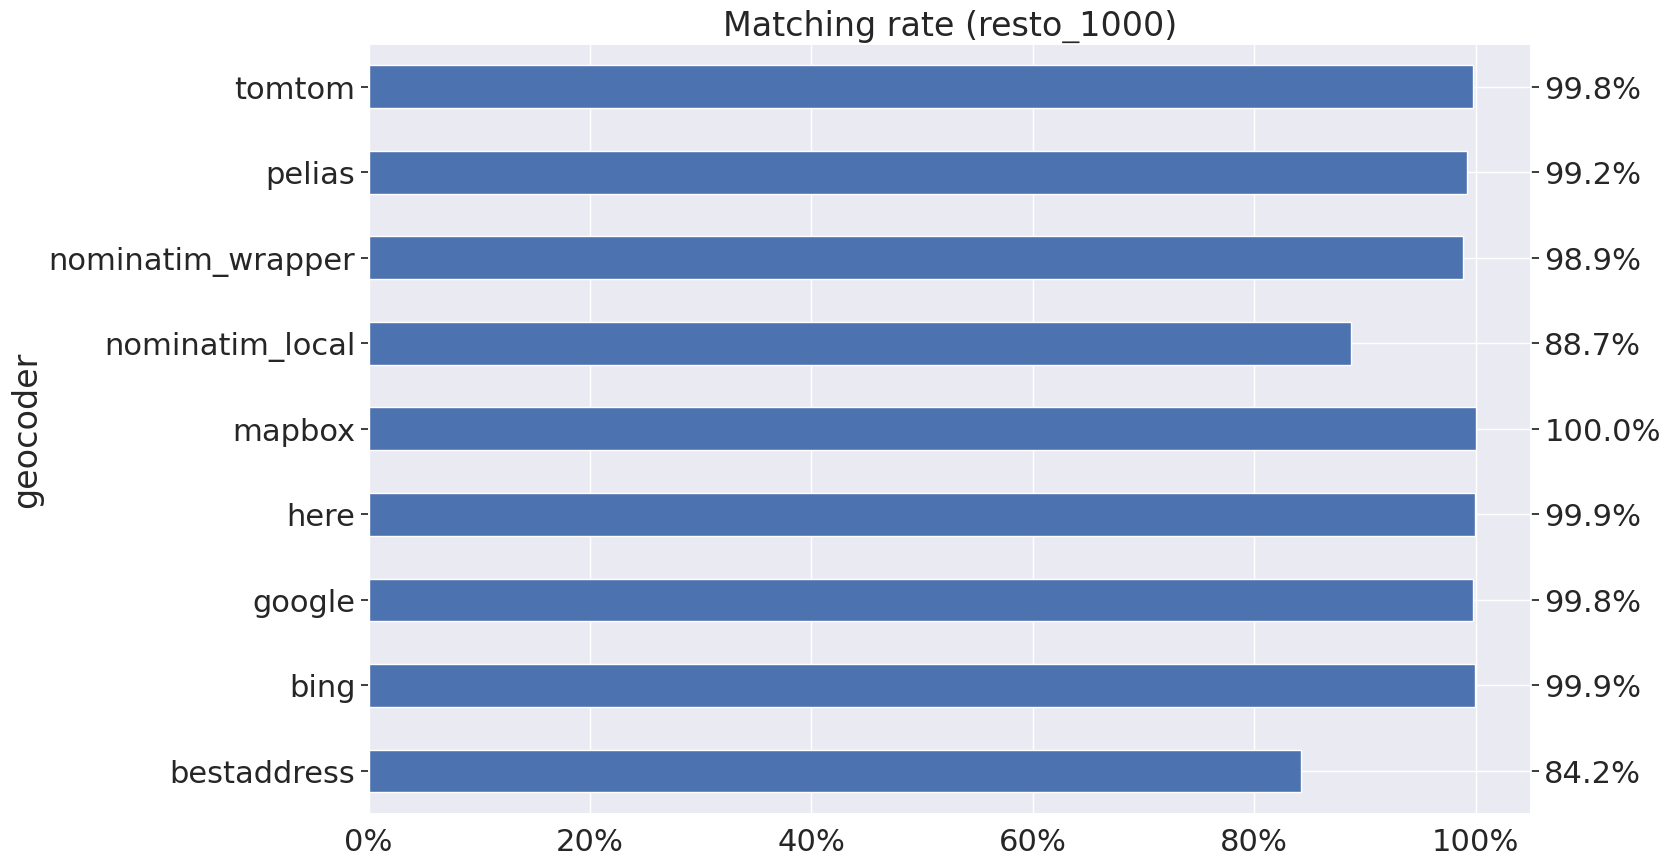

In [2481]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=(15,10))
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)



<Axes: title={'center': 'Number of success per address'}>

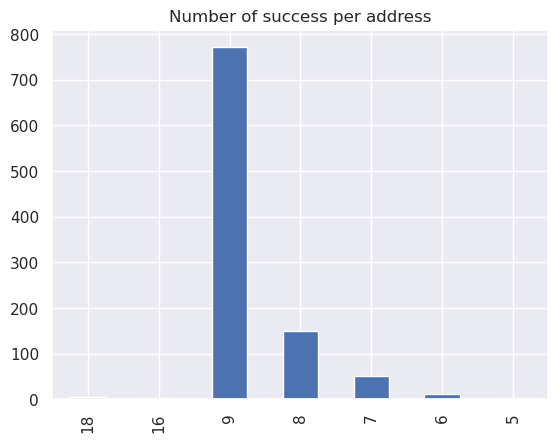

In [2482]:
geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Precision

In [2483]:
# geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack().plot.bar(stacked=True)
# plt.savefig(f"{fig_path}/matching_rate_precision_{dataset}.png")
mr

geocoder
bestaddress          0.842
bing                 0.999
google               0.998
here                 0.999
mapbox               1.000
nominatim_local      0.887
nominatim_wrapper    0.989
pelias               0.992
tomtom               0.998
Name: address, dtype: float64

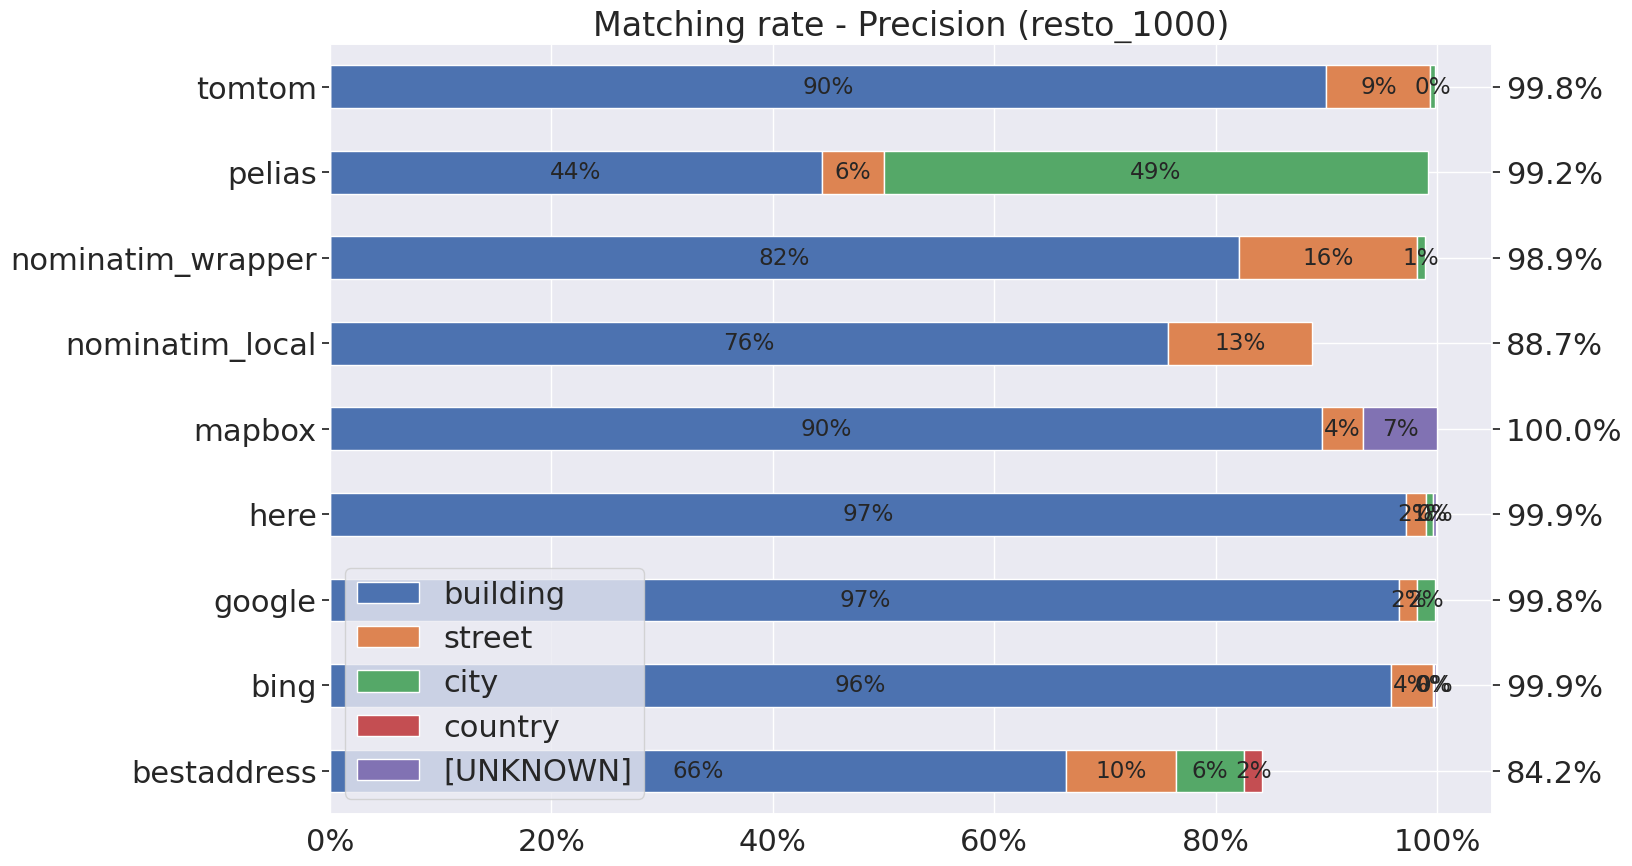

In [2484]:
sbn.set(font_scale=2)
mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/data.shape[0]
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)
mr_prec_plot= mr_prec.plot.barh(stacked=True, figsize=(15,10), title=f"Matching rate - Precision ({dataset})")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

mr_prec_plot.set_ylabel(None)


plt.legend(loc='lower left')

show_values_on_hbars(mr_prec_plot, mr)

for bars in mr_prec_plot.containers:
    mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0 else "", fontproperties={"size":"x-small"})

    
plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)


In [2485]:
mr_prec #59/23/18

precision          building  street   city  country  [UNKNOWN]
geocoder                                                      
bestaddress           0.665   0.099  0.062    0.016        NaN
bing                  0.958   0.038  0.001      NaN      0.002
google                0.966   0.016  0.016      NaN        NaN
here                  0.972   0.018  0.006      NaN      0.003
mapbox                0.896   0.037    NaN      NaN      0.067
nominatim_local       0.757   0.130    NaN      NaN        NaN
nominatim_wrapper     0.821   0.161  0.007      NaN        NaN
pelias                0.444   0.056  0.492      NaN        NaN
tomtom                0.900   0.094  0.004      NaN        NaN

In [2486]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))




precision          building  street  city country [UNKNOWN]
geocoder                                                   
bestaddress           66.5%    9.9%  6.2%    1.6%          
bing                  95.8%    3.8%  0.1%              0.2%
google                96.6%    1.6%  1.6%                  
here                  97.2%    1.8%  0.6%              0.3%
mapbox                89.6%    3.7%                    6.7%
nominatim_local       75.7%   13.0%                        
nominatim_wrapper     82.1%   16.1%  0.7%                  
pelias                44.4%    5.6% 49.2%                  
tomtom                90.0%    9.4%  0.4%

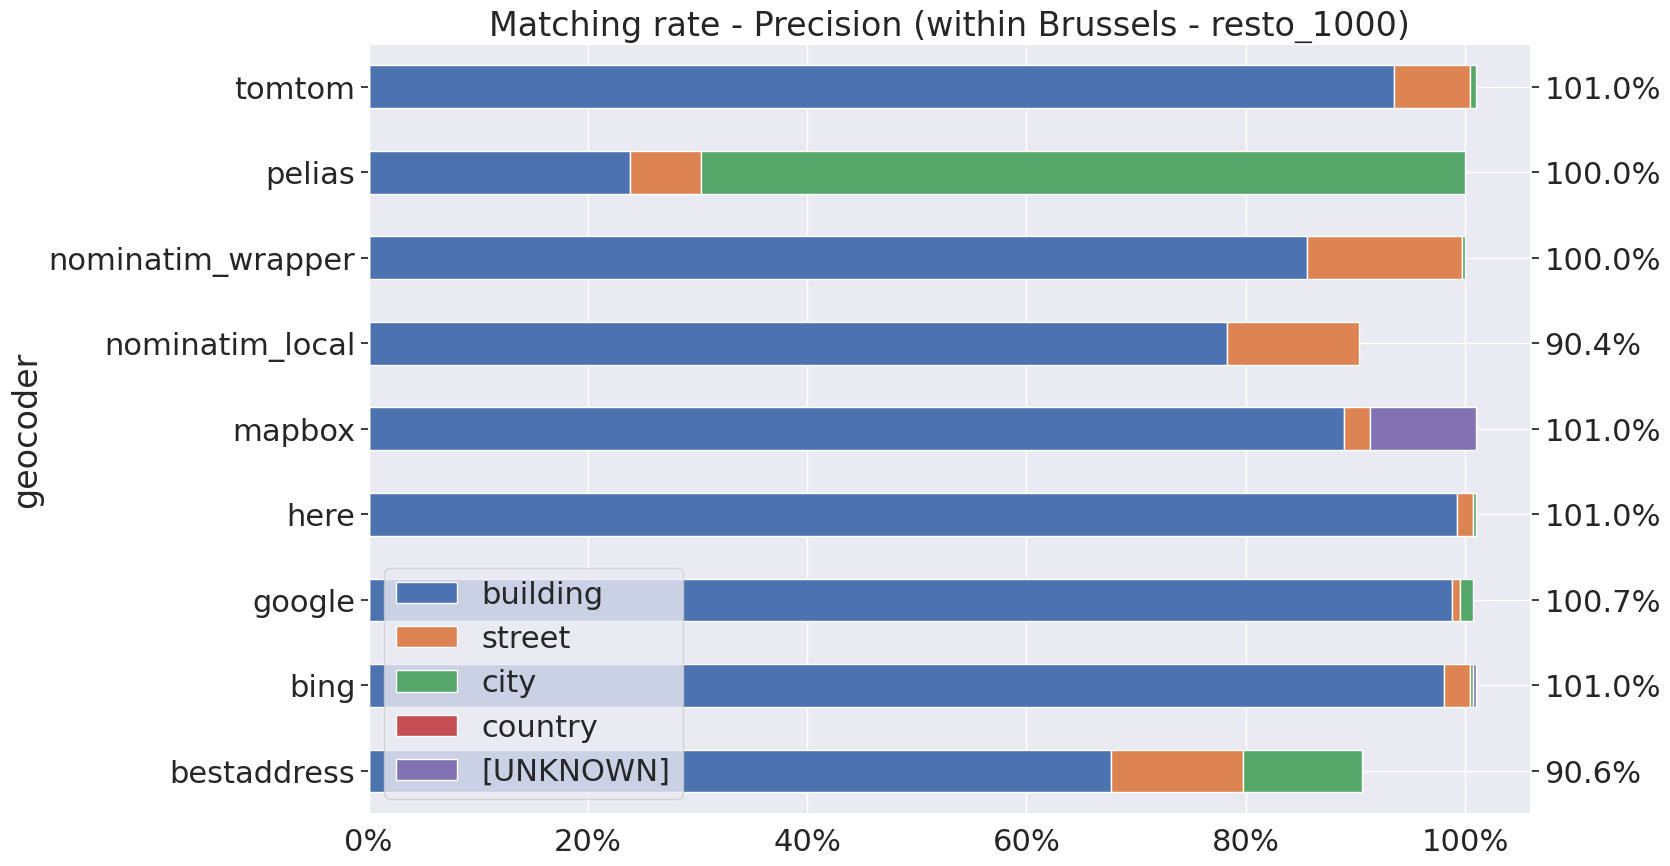

In [2487]:
bru_boundaries = gpd.read_file("data/boundaries.geojson")
bru_boundaries = bru_boundaries[bru_boundaries.name == "BRU"].geometry.iloc[0].simplify(1000).buffer(1000)

addr_in_bru = geocoded_data[geocoded_data.point.within(bru_boundaries)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 


sbn.set(font_scale=2)
mr_prec = geocoded_data_bru.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/geocoded_data_bru.address.nunique()
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)

mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                figsize=(15,10), 
                                title=f"Matching rate - Precision (within Brussels - {dataset})")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')


plt.legend(loc='lower left')



mr_bru = (geocoded_data_bru.groupby("geocoder").address.count()/ geocoded_data_bru.address.nunique())

show_values_on_hbars(mr_prec_plot, mr_bru)


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)

In [2488]:
# geocoded_data[geocoded_data.point.within(bru_boundaries)]

In [2489]:
mr_prec

precision          building    street      city  country  [UNKNOWN]
geocoder                                                           
bestaddress        0.677108  0.120482  0.108434      NaN        NaN
bing               0.980723  0.024096  0.002410      NaN   0.002410
google             0.987952  0.007229  0.012048      NaN        NaN
here               0.992771  0.014458  0.002410      NaN        NaN
mapbox             0.889157  0.024096       NaN      NaN   0.096386
nominatim_local    0.783133  0.120482       NaN      NaN        NaN
nominatim_wrapper  0.855422  0.142169  0.002410      NaN        NaN
pelias             0.238554  0.065060  0.696386      NaN        NaN
tomtom             0.934940  0.069880  0.004819      NaN        NaN

In [2490]:
# geocoded_data[(geocoded_data.geocoder=="pelias") & (geocoded_data.precision == "city")]

In [2491]:
# geocoded_data.loc[1871].location.raw

In [2492]:
# geocoders["pelias"].geocode("Bruynebosstraat, 40, 3511 Hasselt, Belgique").raw


In [1198]:
# geocoders["nominatim"].geocode("Rue Nicolas Arnold, 4800 Verviers")

## Distance to median

### Average

geocoder
bestaddress             4.780248
nominatim_local         4.805541
nominatim_wrapper       4.780248
pelias               5321.567753
Name: dist_to_median, dtype: float64

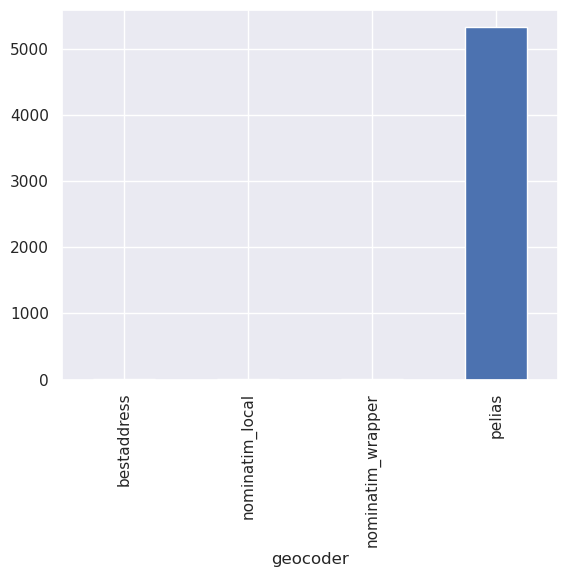

In [1199]:
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

In [1200]:
# geocoded_data.pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

In [1201]:
# # skipping top 1%
# d2m = geocoded_data[geocoded_data.is_value_normal].groupby("geocoder").dist_to_median.mean()
# d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_skip1pc_{dataset}.png")
# d2m

In [1202]:
# geocoded_data[geocoded_data.is_value_normal].pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

geocoder
bestaddress             4.780248
nominatim_local         4.805541
nominatim_wrapper       4.780248
pelias               5321.567753
Name: dist_to_median, dtype: float64

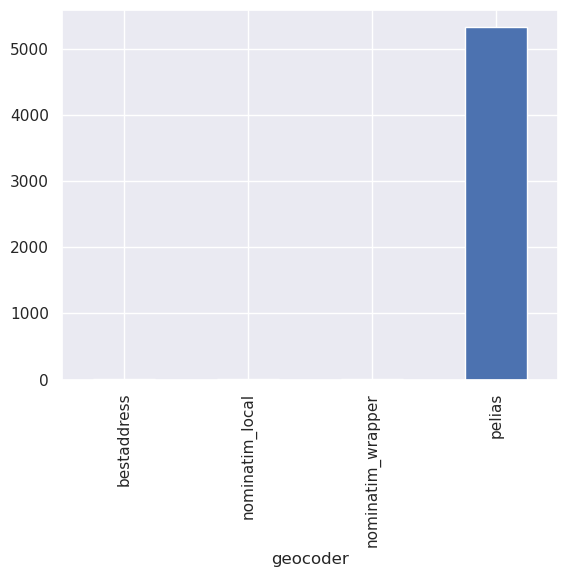

In [1203]:
# skipping non reliable median

d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

geocoder
bestaddress             4.780248
nominatim_local         4.805541
nominatim_wrapper       4.780248
pelias               2675.495770
Name: dist_to_median, dtype: float64

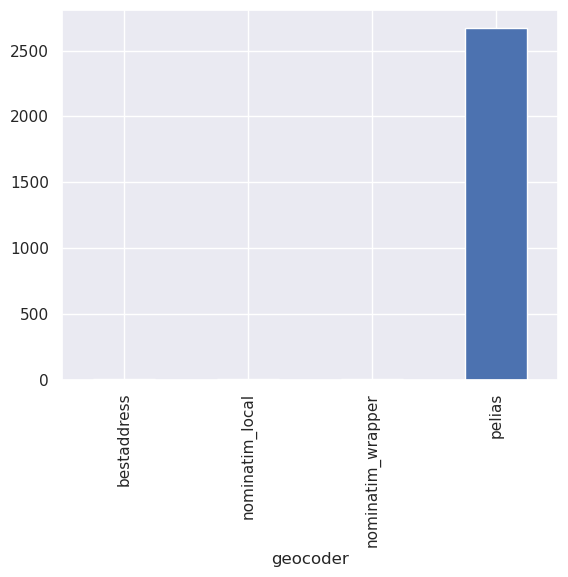

In [1204]:
d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

In [1205]:
geocoded_data[geocoded_data.dist_to_median>100000]

street housenumber postcode                city  \
1888  Rue Maurice Van Rolleghem          66     1090               Jette   
1946           Rue Arsène Falla          40     4621              Fléron   
1949              Avenue Louise         489     1050             Ixelles   
2145         Rue Charles Demeer          73     1020           Bruxelles   
2160       Avenue Jules Génicot           5     1160           Auderghem   
2214              Avenue Louise         143     1050             Ixelles   
2244  Rue du Père Nicolas Hardy           4     4890  Thimister-Clermont   
2338                 Rue Darwin          62     1050             Ixelles   
2350         Rue Victor Greyson          35     1050             Ixelles   
2364               Rue Franklin           2     1000           Bruxelles   
2392           Peter Benoitlaan          72     8530           Harelbeke   
2404         rue des Maraîchers           9     1070          Anderlecht   
2408        Rue Antoine Labarre          38     1050             Ixelles   
2420             Rue du Paradis          55     4432                 Ans   
2524          Rue Van Artevelde          19     1000           Bruxelles   
2543              Avenue Louise         505     1050             Ixelles   
2616          Rue Victor Rauter         288     1070          Anderlecht   

                                                address  \
1888  Rue Maurice Van Rolleghem, 66, 1090 Jette, Bel...   
1946        Rue Arsène Falla, 40, 4621 Fléron, Belgique   
1949         Avenue Louise, 489, 1050 Ixelles, Belgique   
2145   Rue Charles Demeer, 73, 1020 Bruxelles, Belgique   
2160  Avenue Jules Génicot, 5, 1160 Auderghem, Belgique   
2214         Avenue Louise, 143, 1050 Ixelles, Belgique   
2244  Rue du Père Nicolas Hardy, 4, 4890 Thimister-C...   
2338             Rue Darwin, 62, 1050 Ixelles, Belgique   
2350     Rue Victor Greyson, 35, 1050 Ixelles, Belgique   
2364          Rue Franklin, 2, 1000 Bruxelles, Belgique   
2392     Peter Benoitlaan, 72, 8530 Harelbeke, Belgique   
2404   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   
2408    Rue Antoine Labarre, 38, 1050 Ixelles, Belgique   
2420             Rue du Paradis, 55, 4432 Ans, Belgique   
2524    Rue Van Artevelde, 19, 1000 Bruxelles, Belgique   
2543         Avenue Louise, 505, 1050 Ixelles, Belgique   
2616  Rue Victor Rauter, 288, 1070 Anderlecht, Belgique   

                                               location geocoder  duration  \
1888  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
1946         (Rue Arsène Matton, (50.703508, 4.662561))   pelias       NaN   
1949  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2145  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2160  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2214  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2244          (Rue du Père Pire, (50.439511, 4.300817))   pelias       NaN   
2338  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2350  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2364  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2392          (Peter Benoitlaan, (50.944398, 4.368062))   pelias       NaN   
2404  (Liège Rue des Maraîchers, (50.640731, 5.590788))   pelias       NaN   
2408  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2420  (Rue du Luxembourg - Luxemburgstraat, (50.8407...   pelias       NaN   
2524  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2543  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   
2616  (Ce que veulent les hommes Invoice address, (5...   pelias       NaN   

     precision                           point  is_in_belgium  \
1888  building  POINT (586972.202 6537126.617)           True   
1946    street  POINT (519033.916 6569014.351)           T

In [1206]:
# geocoded_data[geocoded_data.address == "RUE DE FORET(BZ), 65, 5000 Namur, Belgique"]

In [1207]:
# Boxplot: 
# box: Q1-median(Q2)-Q3
# top whisker:    highest point that falls within Q3 + (Q3-Q1 = IQR) * 1.5 
# bottom whisker: lowest  point that falls within Q1 - (IQR) * 1.5 

def show_precision_stats(geocoded_data, title):
    
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    dist2med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
    
    mr_prec["all"] = geocoded_data.groupby(["geocoder"]).address.count()
    dist2med["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.mean()
    
    fig, ax =plt.subplots(mr_prec.shape[1], 3, figsize=(15, 20)) #
    fig.suptitle(title)
#     plt.gca().set_title(title)
    filters = [(r, (geocoded_data.precision==r)) for r in geocoded_data.precision.unique() if not "UNK" in r]
    filters.append(("all", geocoded_data.precision.notnull()))
    
    colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]
    
#     print(filters)
    for i, (r, fltr) in enumerate(filters): 
        #print(r, i)
        dist2med[r].plot.bar(ax=ax[i][0], color=colors)
        #plt.show()
        
        d= geocoded_data[fltr].drop_duplicates(subset="address")
        d = d.pivot(index="address", columns="geocoder", values="dist_to_median")
        d  =d.reindex(mr_prec.index, axis=1)
        d = d[~d.isnull().all(axis=1)]
        
        try:
            d.plot.box(ax=ax[i][1], rot=90)
        except Exception as e:
            print("Cannot plot: ", e)

        mr_prec[r].plot.bar(ax=ax[i][2], color=colors)

        plt.setp(ax[i, 0], ylabel=r)
        #plt.setp(axs[:, 0], ylabel='y axis label')

    plt.setp(ax[0, 0], title="Average distance")
    plt.setp(ax[0, 1], title="Distance distribution")
    plt.setp(ax[0, 2], title="Number of matches")


In [1208]:
# data[data.address.duplicated()]
# geocoded_data.pivot(columns="geocoder", values="dist_to_median")#.reset_index()

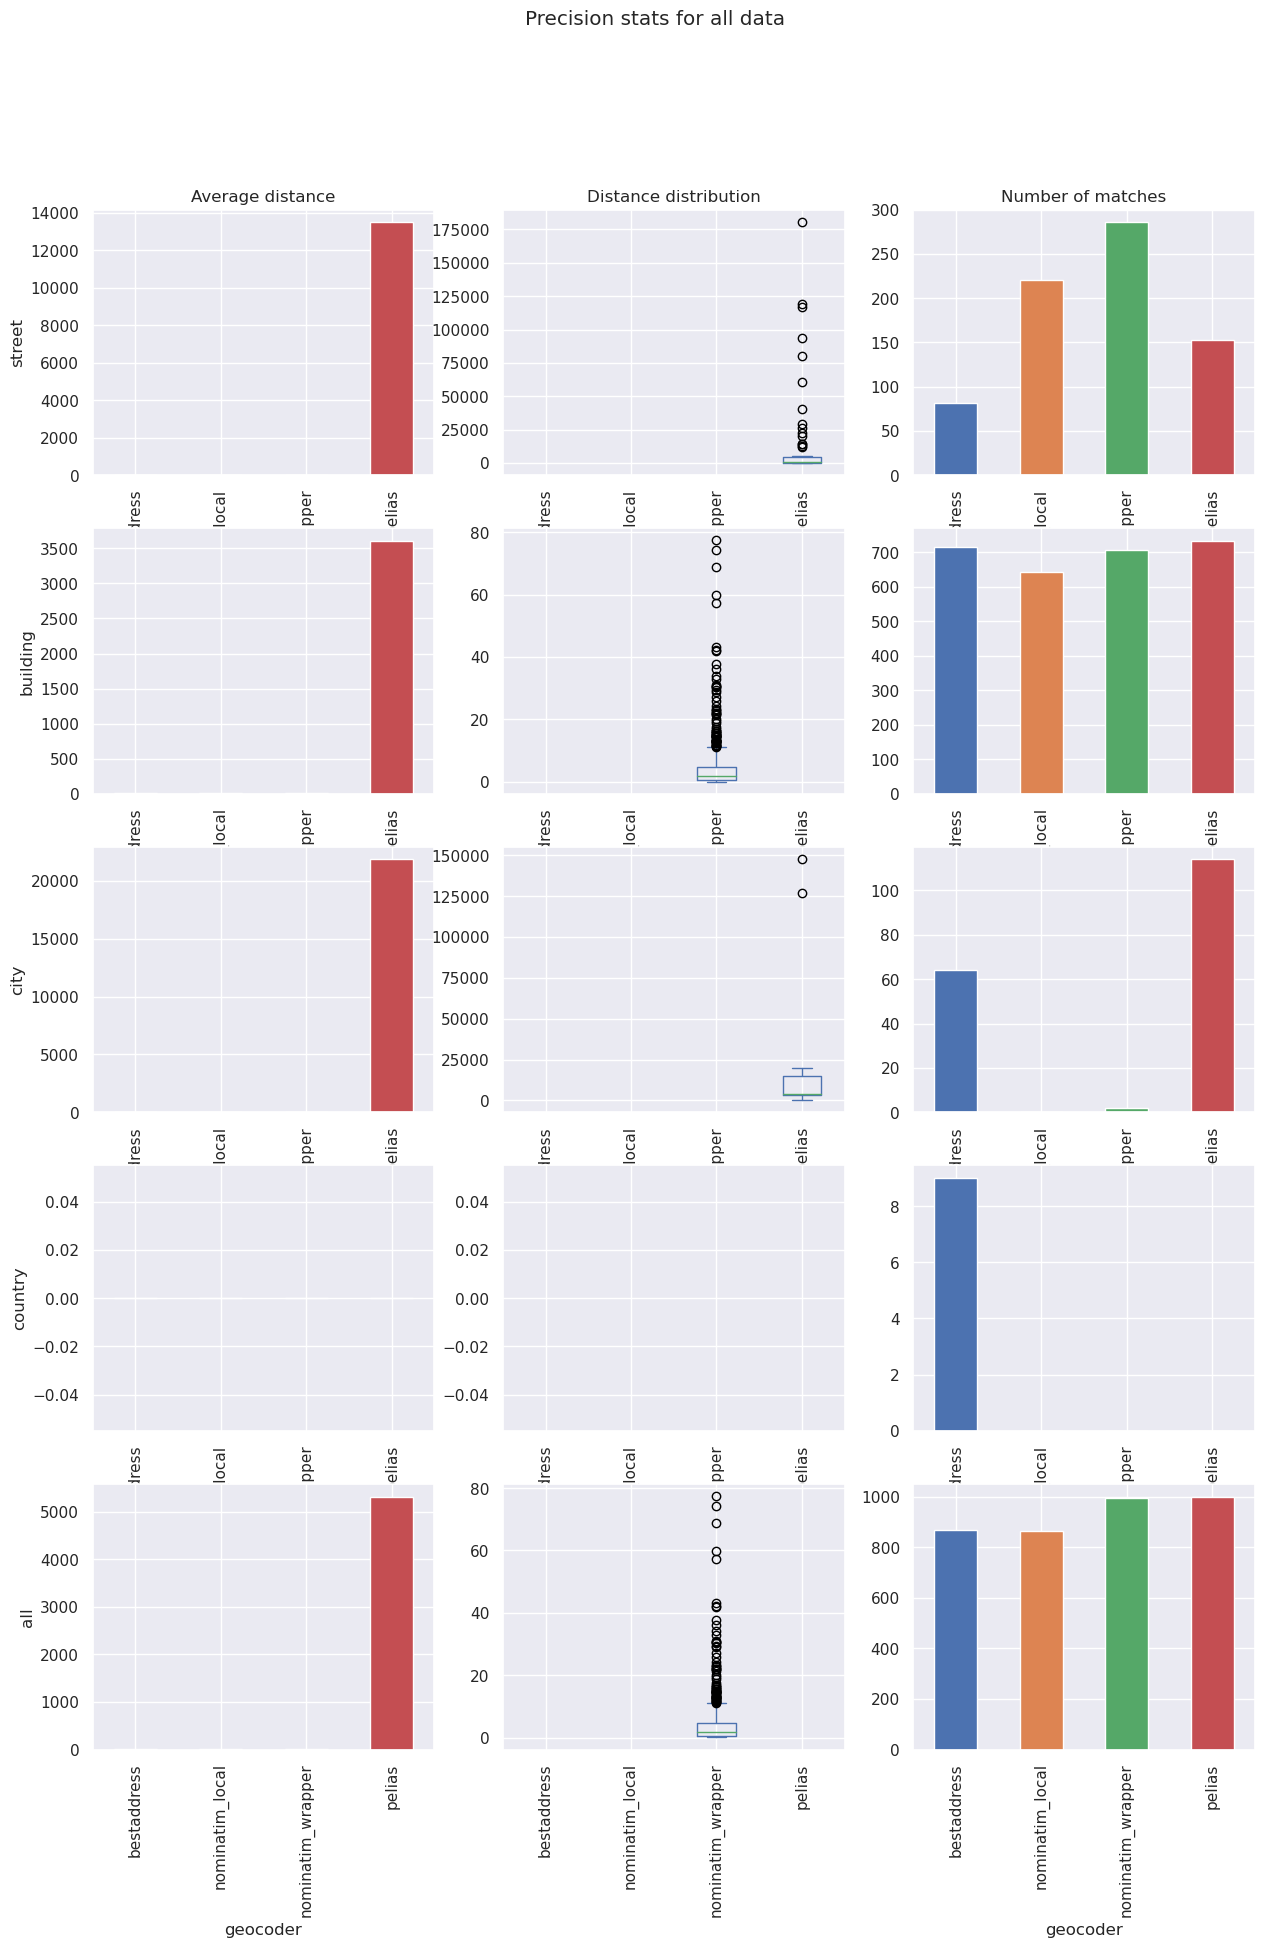

In [1209]:
d = show_precision_stats(geocoded_data, "Precision stats for all data")

# img_name=f"{fig_path}/precision_stats_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


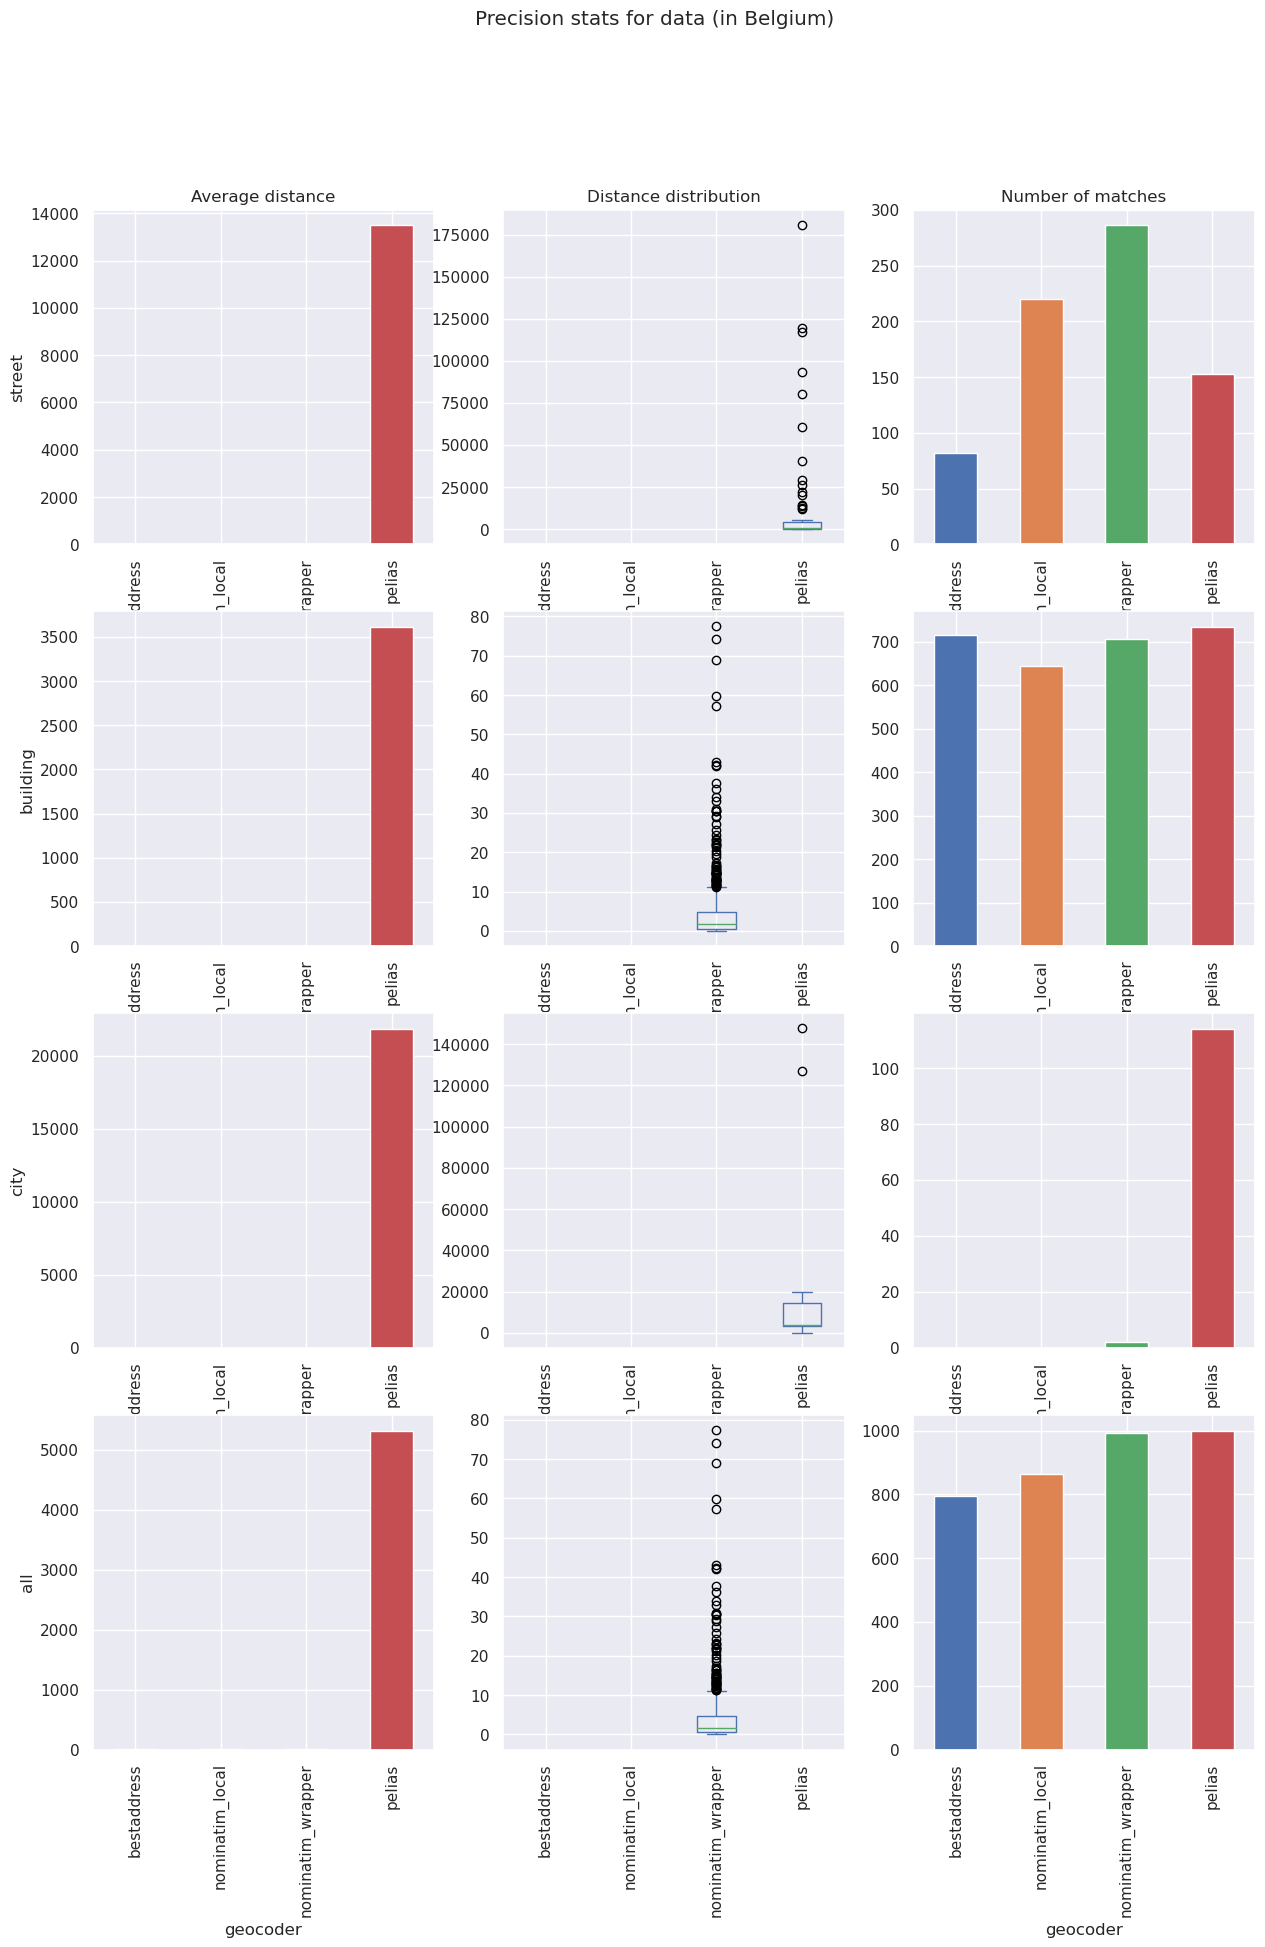

In [1210]:
show_precision_stats(geocoded_data[geocoded_data.is_in_belgium], "Precision stats for data (in Belgium)")
pdf.savefig()

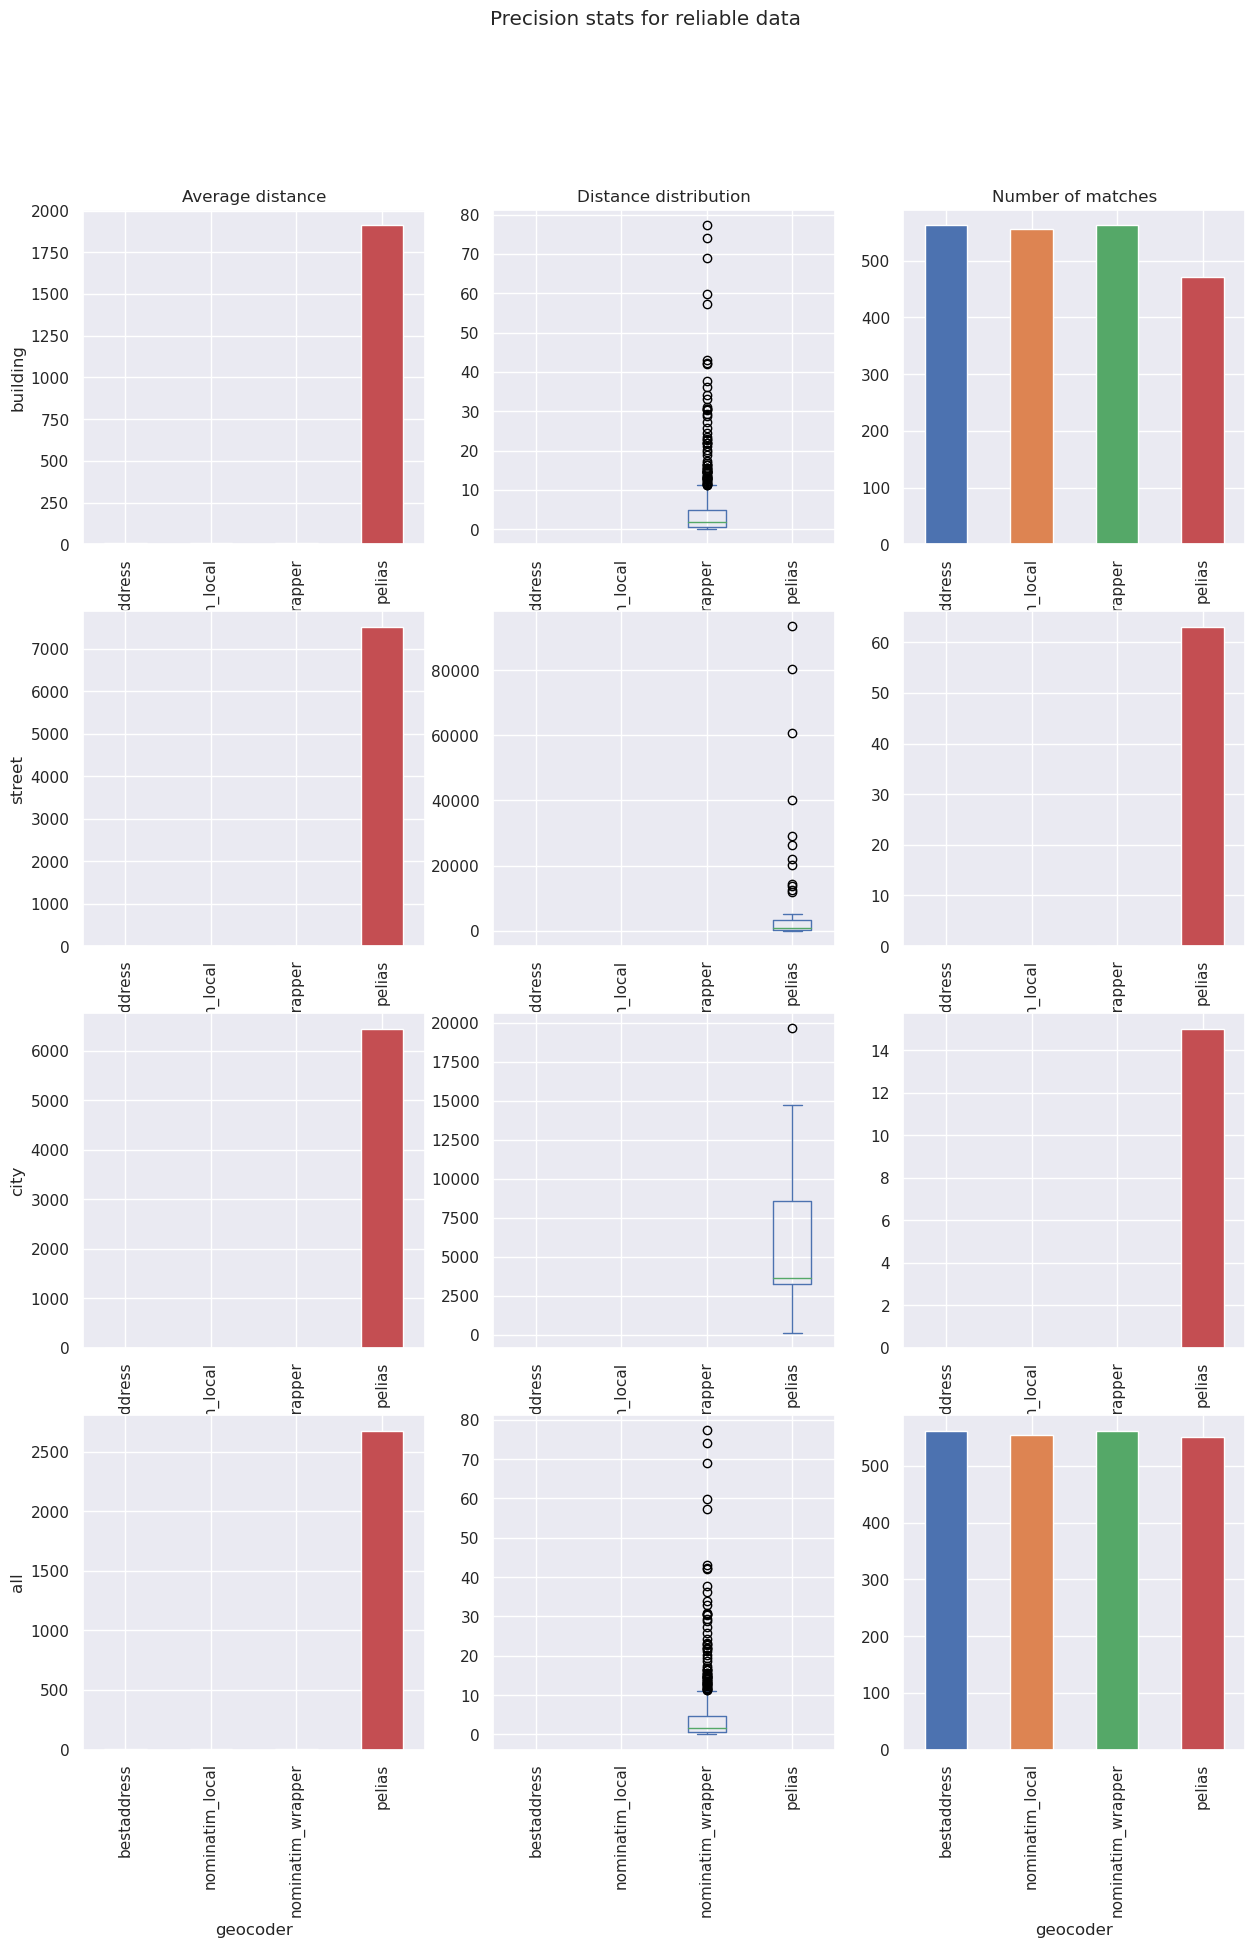

In [1211]:
show_precision_stats(geocoded_data[geocoded_data.is_reliable], "Precision stats for reliable data")

# img_name=f"{fig_path}/precision_stats_reliable_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


In [1212]:
# tics = sorted([10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)])
# pd.cut(geocoded_data.dist_to_median.dropna(), tics, include_lowest=True)

### Distribution

In [1213]:
def plot_dist_to_median_distrib(geocoded_data, plotter="px", title=None, filename=None):
    tics = sorted([0] + [10**i for i in range(1, 6)] + [2*10**i for i in range(1, 6)]  +[5*10**i for i in range(1, 6)])
    geocoded_data  = geocoded_data.dropna(subset=["dist_to_median"])
    geocoded_data = geocoded_data.assign(dist_to_median_bins = pd.cut(geocoded_data.dist_to_median, tics, include_lowest=True))
    df = geocoded_data.groupby(["dist_to_median_bins","geocoder"]).address.count().unstack()

    title = 'Distance to median'+(f" ({title})" if title else"")
    if plotter=="plt":

        ax = df.plot(figsize=(15,10), title=title)#.hist()
        ax.set_ylim(0, 100)
        if filename:
            plt.savefig(filename, bbox_inches='tight')

            
    else:
        df = df.reset_index()
        df["x"] = df.dist_to_median_bins.apply(lambda x: x.right)
        fig = px.line(df, x="x", y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        #fig.set_ylim(0, 200)
        fig.show()

    #plt.savefig(f"{fig_path}/dist2med_distrib_{dataset}.png")

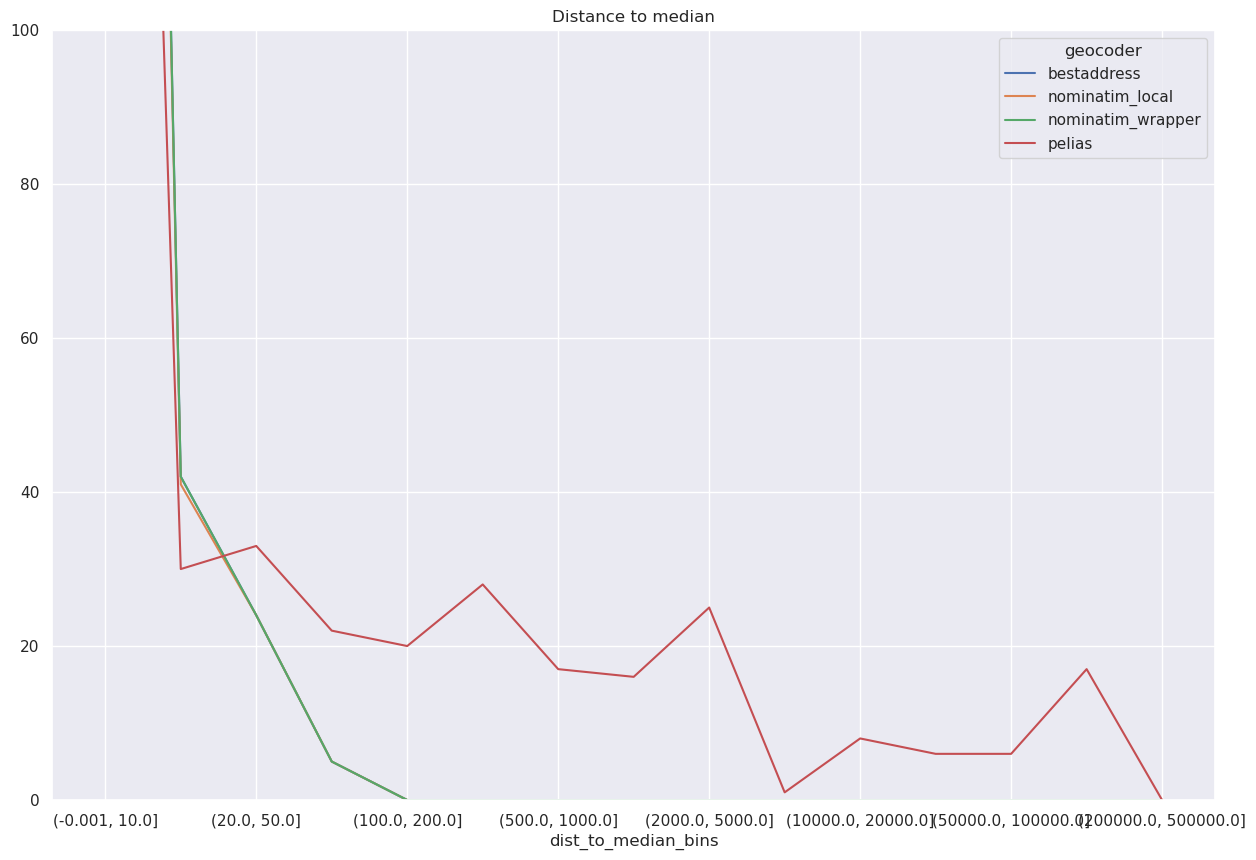

In [1214]:
# img_name=f"{fig_path}/dist2med_distrib_{dataset}.png"
img_name=None
plot_dist_to_median_distrib(geocoded_data, "plt", 
                            filename=img_name)

# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()


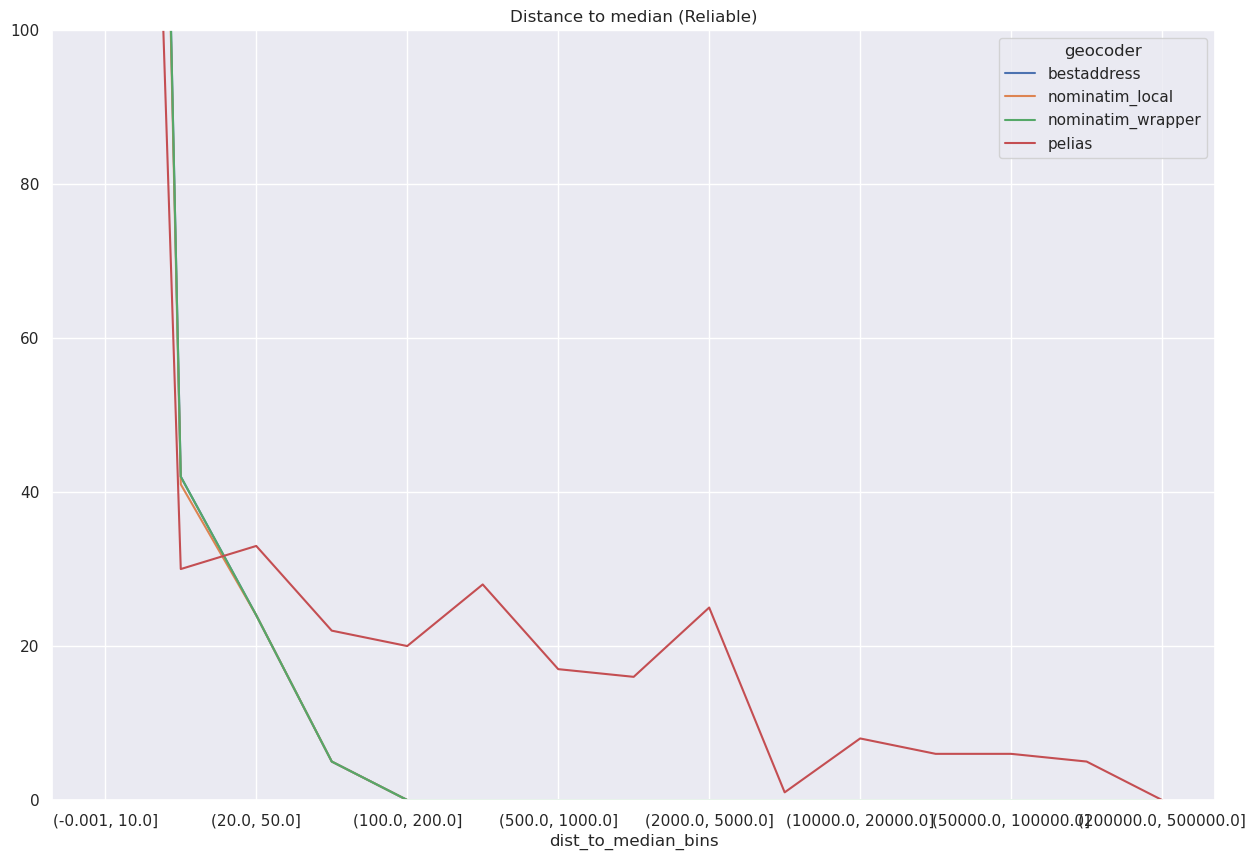

In [1215]:
# img_name=f"{fig_path}/dist2med_distrib_reliable_{dataset}.png"

plot_dist_to_median_distrib(geocoded_data[geocoded_data.is_reliable], "plt", 
                            title="Reliable", 
                            filename=img_name)
# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()



In [1216]:
addresses_found_by_NW = geocoded_data[(geocoded_data.geocoder == "nominatim_wrapper") & (geocoded_data.precision == "building")].address
if addresses_found_by_NW.shape[0]>0:
    plot_dist_to_median_distrib(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], 
                            title="for addr. found by NW at build. level")


### Ratio

In [1217]:
def plot_threshold_ratio(geocoded_data, plotter="px", title=None, filename=None):
    thresh_ratio = pd.DataFrame()
    for gc in geocoded_data.geocoder.unique():
        g_data = geocoded_data[geocoded_data.geocoder == gc]
        for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
            thresh_ratio = pd.concat([thresh_ratio, pd.DataFrame([{"geocoder": gc, 
                                                "threshold": thresh, 
                                                "ratio": g_data[g_data.dist_to_median <= thresh].shape[0]/g_data.shape[0]}])])
    
    df = thresh_ratio.set_index("threshold").pivot(columns="geocoder", values="ratio")
    
    title = 'Ratio below threshold'+(f" ({title})" if title else"")
    if plotter=="plt":
        df.plot.line(logx=True, figsize=(15,10),  title=title)#x="ratio", y="threshold")
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else :
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        fig.show()

    ##return thresh_ratio

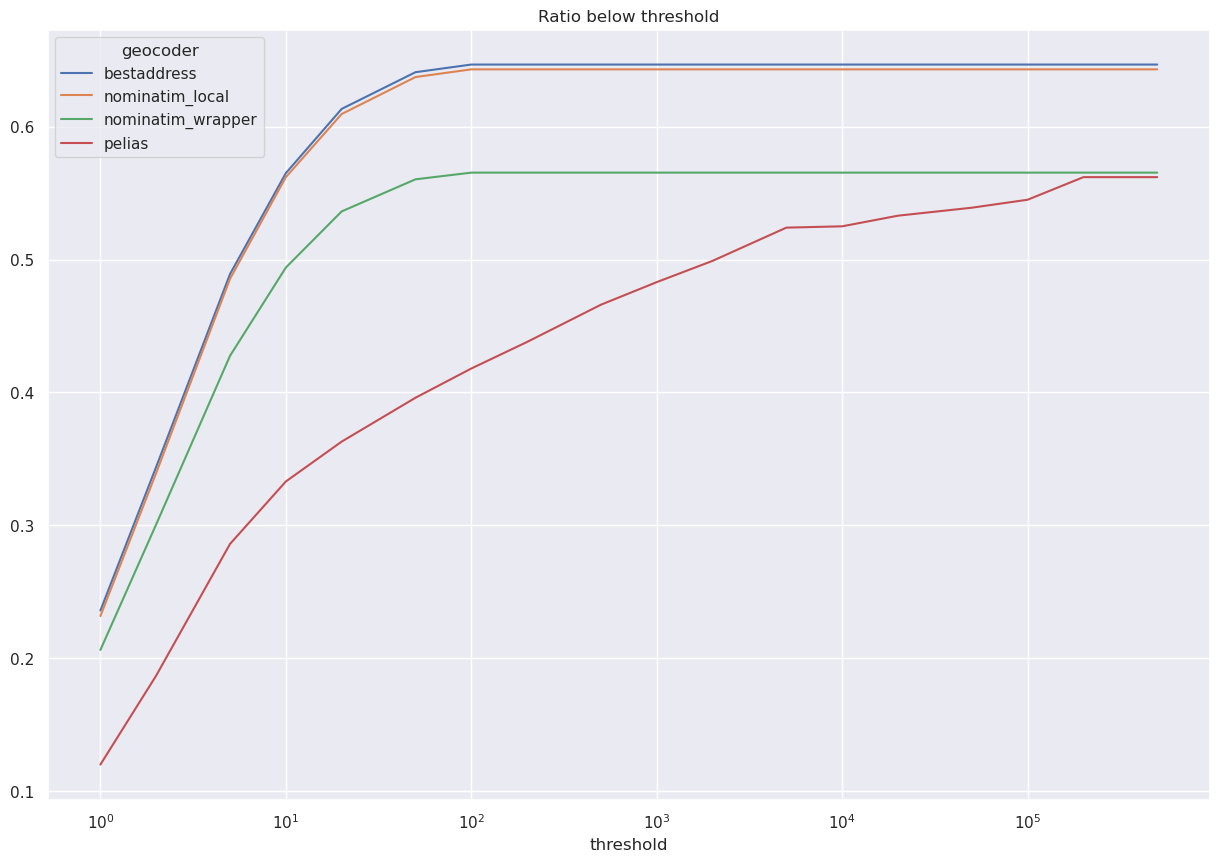

In [1218]:
# img_name=f"{fig_path}/dist2med_thresholds_{dataset}.png"

plot_threshold_ratio(geocoded_data, "plt")

pdf.savefig()
# plt.show()
# plt.close()


# pdf_add_image(pdf, img_name)

# plt.savefig(f"{fig_path}/dist2med_thresholds_{dataset}.png")

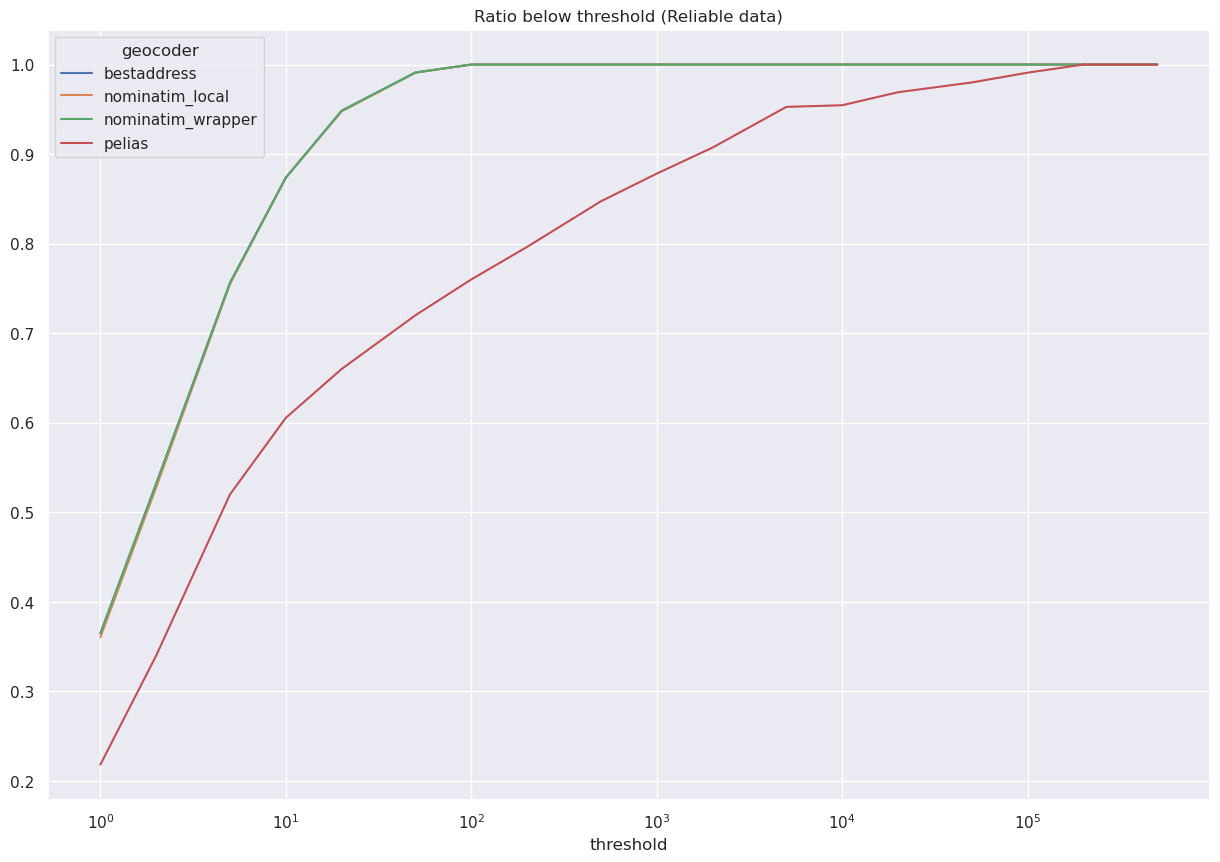

In [1219]:
# img_name=f"{fig_path}/dist2med_thresholds_reliable_{dataset}.png"

# plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data", filename=img_name)

# pdf_add_image(pdf, img_name)


plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data")

pdf.savefig()
# plt.show()
# plt.close()



#

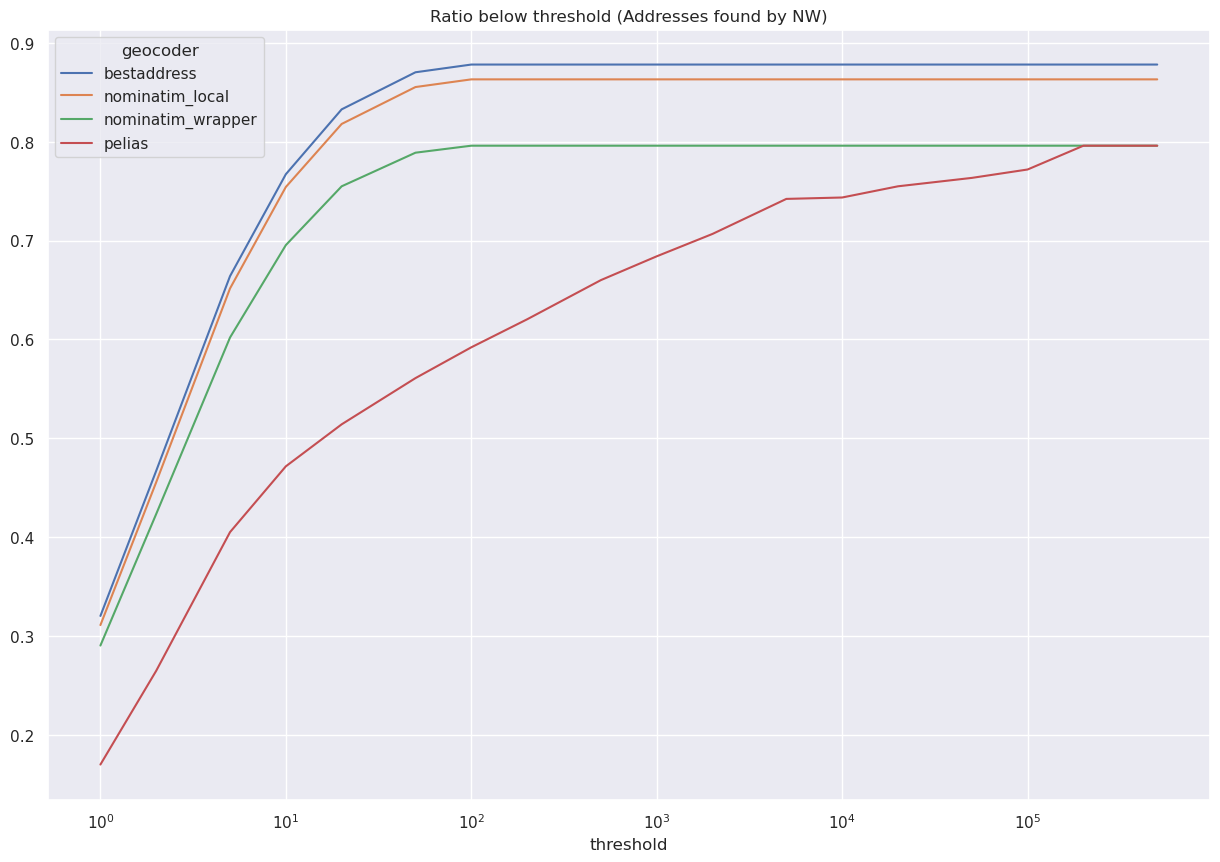

In [1220]:
if addresses_found_by_NW.shape[0]>0:
    plot_threshold_ratio(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], "plt", title="Addresses found by NW")

## Ratio far from median

In [1221]:
def get_far_from_threshold(geocoded_data, plotter="plt", filename=None, title=f"Number of results 'threshold' away from median ({dataset})"):
    far_from_tresh = []
    #for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
    for thresh in [10**i for i in range(2, 8)] + [2*10**i for i in range(2, 7)]  +[5*10**i for i in range(2, 7)]:
        d = geocoded_data[geocoded_data.dist_to_median > thresh].geocoder.value_counts().rename("count_far_from_med").reset_index().rename({"index": "geocoder"}, axis=1)
        d["threshold"] = thresh
        far_from_tresh.append(d)
    far_from_tresh = pd.concat(far_from_tresh)#.set_index("index")
    df = far_from_tresh.set_index("threshold").pivot(columns="geocoder", values="count_far_from_med")#.fillna(0)
    #display(df)
    if plotter=="plt":
        df.plot(logx=True, logy=False, figsize=(10,6), title=title)
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else:
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title="Number of results 'threshold' away from median", log_x=True)
        fig.show()
    

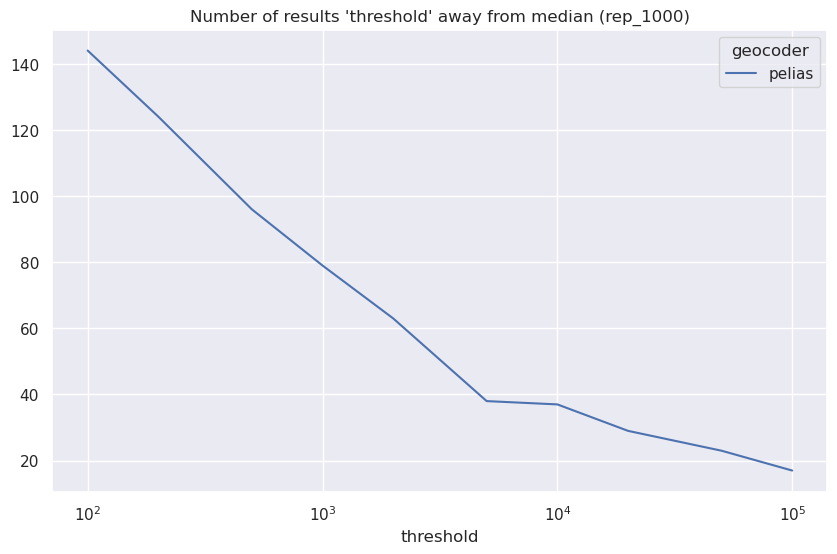

In [1222]:
# img_name=f"{fig_path}/far_from_thresholds_{dataset}.png"
get_far_from_threshold(geocoded_data, "plt") #, img_name)

pdf.savefig()
# plt.show()
# plt.close()

# pdf_add_image(pdf, img_name)




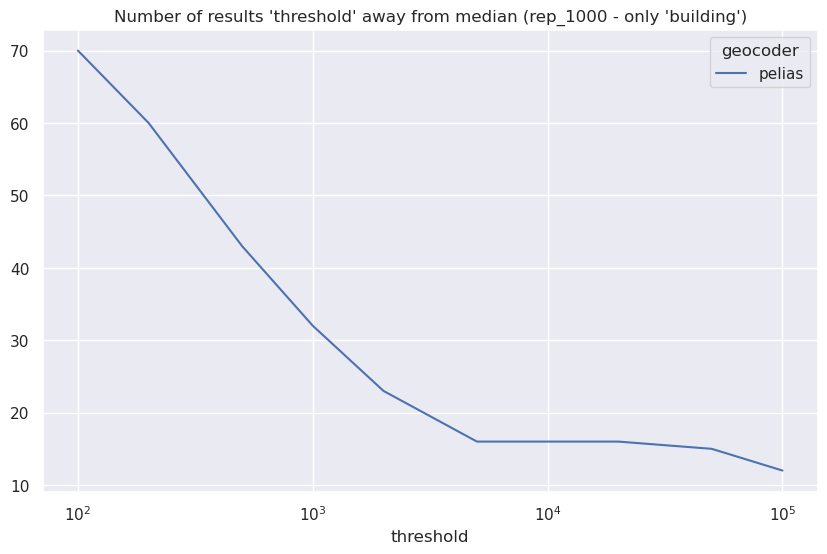

In [1223]:
get_far_from_threshold(geocoded_data[(geocoded_data.precision=="building")], 
                       title = f"Number of results 'threshold' away from median ({dataset} - only 'building')")

pdf.savefig()

In [1224]:
pdf.close()